In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
from datetime import datetime
from toolz.curried import pipe, curry, compose

warnings.filterwarnings('ignore')

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [4]:
import chnet.utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
from chnet.torchsummary import summary
from chnet.ch_loader import CahnHillDataset

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

## Loss Functions

In [99]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

def get_primes(n):
    # https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n-in-python/3035188#3035188
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=np.bool)
    sieve[0] = False
    for i in range(int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[      ((k*k)//3)      ::2*k] = False
            sieve[(k*k+4*k-2*k*(i&1))//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0]+1)|1)]

## Data Generators

In [62]:
@curry
def init_norm(nsamples, dim_x, dim_y, seed=354875, m_l=-0.15, m_r=0.15):
    np.random.seed(seed)
    means  = np.random.uniform(m_l, m_r, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.01, 0.1, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.98, 0.98, out=x_data)
    
    return x_data


@curry
def data_generator(nsamples=2, 
                   dim_x=64, 
                   init_steps=1, 
                   delta_sim_steps = 100,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   m_l=-0.15, 
                   m_r=0.15,
                   seed = 354875,
                   device = torch.device("cuda:0")):
    
    init_data = init_norm(nsamples, dim_x, dim_x, seed=seed, m_l=m_l, m_r=m_r)   

    x_data = ch.ch_run_torch(init_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, 
                             device=device)    

    y_data = ch.ch_run_torch(x_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, 
                             device=device)    
    return x_data, y_data

In [8]:
x_data, y_data = data_generator(nsamples=4, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

# Set Device

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [10]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).to(device)
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,216
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,432
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

(tensor(7762465), tensor(7762465))

In [11]:
from chnet.unet2d import UNet2D
model = UNet2D(in_ch=1, 
                out_ch=1, 
                degree=32).to(device)
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
       ConvBlock2d-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

(tensor(8636769), tensor(8636769))

In [12]:
from chnet.lstm_unet import Unet_solo
model = Unet_solo(input_nc=1, output_nc=1, ngf=32).to(device)
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
       ConvBlock2d-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

(tensor(8636769), tensor(8636769))

In [14]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [19]:
from chnet.lstm_unet import Unet_solo
model = Unet_solo(input_nc=1, output_nc=1, ngf=32).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.1263, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [ ]:
## Process Parameters
dim_x=96
init_steps=1
delta_sim_steps=2500
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
n_samples_trn = 1024*2
ngf = 32

In [ ]:
%%time
x_trn, y_trn = data_generator(nsamples=2, 
                              dim_x=dim_x, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =seed_trn,
                              device = device)

In [ ]:
utils.draw_by_side([x_trn[0], y_trn[0]], sub_titles=["training input", "training output"])

In [102]:
from chnet.lstm_unet import Unet_solo
model = Unet_solo(input_nc=1, output_nc=1, ngf=32).double().to(device)

criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [105]:
primes = get_primes(10000)

In [106]:
num_epochs = 5
for num, prime in enumerate(primes):
    # Loss and optimizer
    x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                                  dim_x=dim_x, 
                                  init_steps=init_steps, 
                                  delta_sim_steps = delta_sim_steps,
                                  dx=dx, 
                                  dt=dt,
                                  m_l=-0.5, 
                                  m_r=+0.5,
                                  gamma=gamma, 
                                  seed=2513*prime,
                                  device = device)


    trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
    trn_loader = DataLoader(trn_dataset, batch_size=8, shuffle=True, num_workers=4)
    print("Training Run: {}".format(num))
    
    for epoch in range(num_epochs):  
        torch.save(model.state_dict(), "unet_model_ch{}_{}_{}_general.pt".format(ngf, init_steps, delta_sim_steps))
        for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):


            model.train()

            x = item_trn['x'].to(device)
            y_tru = item_trn['y'].to(device)

            # Forward pass
            y_prd = model(x)
            loss = criterion(y_tru, y_prd)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trn_losses.append(np.sqrt(loss.item()))

            if (i) % 256 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}'.format(epoch+1, 
                                                                                     num_epochs, 
                                                                                     i+1, 
                                                                                     total_step, 
                                                                                     np.mean(trn_losses[-16:])))

Training Run: 0


Epoch [1/5], Step [1/384], Training Loss: 13.05026683660



Epoch [2/5], Step [1/384], Training Loss: 16.47573800993



Epoch [3/5], Step [1/384], Training Loss: 15.94278699545



Epoch [4/5], Step [1/384], Training Loss: 15.12413849600



Epoch [5/5], Step [1/384], Training Loss: 14.18244983984

Training Run: 1


Epoch [1/5], Step [1/384], Training Loss: 13.95030014056



Epoch [2/5], Step [1/384], Training Loss: 16.61242421878



Epoch [3/5], Step [1/384], Training Loss: 15.61133725102



Epoch [4/5], Step [1/384], Training Loss: 14.54988306625



Epoch [5/5], Step [1/384], Training Loss: 15.24097751409

Training Run: 2


Epoch [1/5], Step [1/384], Training Loss: 13.92633810904



Epoch [2/5], Step [1/384], Training Loss: 17.31288265265



Epoch [3/5], Step [1/384], Training Loss: 15.13697976623



Epoch [4/5], Step [1/384], Training Loss: 14.95856403480



Epoch [5/5], Step [1/384], Training Loss: 14.22249026070

Training Run: 3


Epoch [1/5], Step [1/384], Training Loss: 13.61615946934



Epoch [2/5], Step [1/384], Training Loss: 15.59313791456



Epoch [3/5], Step [1/384], Training Loss: 15.17717528830



Epoch [4/5], Step [1/384], Training Loss: 13.91245402479



Epoch [5/5], Step [1/384], Training Loss: 13.96953890352

Training Run: 4


Epoch [1/5], Step [1/384], Training Loss: 14.02078198574



Epoch [2/5], Step [1/384], Training Loss: 15.78735827861



Epoch [3/5], Step [1/384], Training Loss: 15.79514125025



Epoch [4/5], Step [1/384], Training Loss: 15.30333510466



Epoch [5/5], Step [1/384], Training Loss: 13.37947536921

Training Run: 5


Epoch [1/5], Step [1/384], Training Loss: 12.96382954135



Epoch [2/5], Step [1/384], Training Loss: 17.17913651075



Epoch [3/5], Step [1/384], Training Loss: 15.68864533010



Epoch [4/5], Step [1/384], Training Loss: 14.48866177443



Epoch [5/5], Step [1/384], Training Loss: 14.31003073308

Training Run: 6


Epoch [1/5], Step [1/384], Training Loss: 13.99093355880



Epoch [2/5], Step [1/384], Training Loss: 15.36321747578



Epoch [3/5], Step [1/384], Training Loss: 14.93984804160



Epoch [4/5], Step [1/384], Training Loss: 13.68471416234



Epoch [5/5], Step [1/384], Training Loss: 15.18308999532

Training Run: 7


Epoch [1/5], Step [1/384], Training Loss: 12.96178310395



Epoch [2/5], Step [1/384], Training Loss: 16.40810966307



Epoch [3/5], Step [1/384], Training Loss: 15.31558644146



Epoch [4/5], Step [1/384], Training Loss: 14.80736282055



Epoch [5/5], Step [1/384], Training Loss: 14.84010507070

Training Run: 8


Epoch [1/5], Step [1/384], Training Loss: 14.21975631895



Epoch [2/5], Step [1/384], Training Loss: 16.64140015878



Epoch [3/5], Step [1/384], Training Loss: 14.75994555063



Epoch [4/5], Step [1/384], Training Loss: 14.85669630842



Epoch [5/5], Step [1/384], Training Loss: 13.55291146427

Training Run: 9


Epoch [1/5], Step [1/384], Training Loss: 12.80602118456



Epoch [2/5], Step [1/384], Training Loss: 16.85286405962



Epoch [3/5], Step [1/384], Training Loss: 14.77111720063



Epoch [4/5], Step [1/384], Training Loss: 13.85847341930



Epoch [5/5], Step [1/384], Training Loss: 14.56227626085

Training Run: 10


Epoch [1/5], Step [1/384], Training Loss: 13.56891892626



Epoch [2/5], Step [1/384], Training Loss: 15.32784895559



Epoch [3/5], Step [1/384], Training Loss: 15.91351494974



Epoch [4/5], Step [1/384], Training Loss: 13.89152722511



Epoch [5/5], Step [1/384], Training Loss: 13.71611328587

Training Run: 11


Epoch [1/5], Step [1/384], Training Loss: 13.01113884033



Epoch [2/5], Step [1/384], Training Loss: 16.64816533840



Epoch [3/5], Step [1/384], Training Loss: 14.96767071195



Epoch [4/5], Step [1/384], Training Loss: 15.70585601255



Epoch [5/5], Step [1/384], Training Loss: 15.42741489927

Training Run: 12


Epoch [1/5], Step [1/384], Training Loss: 12.97014806010



Epoch [2/5], Step [1/384], Training Loss: 17.03468296652



Epoch [3/5], Step [1/384], Training Loss: 14.62454489623



Epoch [4/5], Step [1/384], Training Loss: 15.11147062164



Epoch [5/5], Step [1/384], Training Loss: 14.84659177157

Training Run: 13


Epoch [1/5], Step [1/384], Training Loss: 13.71304353381



Epoch [2/5], Step [1/384], Training Loss: 15.11296403275



Epoch [3/5], Step [1/384], Training Loss: 15.77498688680



Epoch [4/5], Step [1/384], Training Loss: 14.95842424433



Epoch [5/5], Step [1/384], Training Loss: 14.93652321332

Training Run: 14


Epoch [1/5], Step [1/384], Training Loss: 14.49822557684



Epoch [2/5], Step [1/384], Training Loss: 15.82885182167



Epoch [3/5], Step [1/384], Training Loss: 14.21825368363



Epoch [4/5], Step [1/384], Training Loss: 14.27272452158



Epoch [5/5], Step [1/384], Training Loss: 13.56519215043

Training Run: 15


Epoch [1/5], Step [1/384], Training Loss: 14.04854645381



Epoch [2/5], Step [1/384], Training Loss: 15.79447587113



Epoch [3/5], Step [1/384], Training Loss: 14.01190855911



Epoch [4/5], Step [1/384], Training Loss: 14.00241347676



Epoch [5/5], Step [1/384], Training Loss: 13.79960238944

Training Run: 16


Epoch [1/5], Step [1/384], Training Loss: 13.25637462825



Epoch [2/5], Step [1/384], Training Loss: 15.14723706288



Epoch [3/5], Step [1/384], Training Loss: 16.76189026137



Epoch [4/5], Step [1/384], Training Loss: 14.48400267122



Epoch [5/5], Step [1/384], Training Loss: 14.28942171749

Training Run: 17


Epoch [1/5], Step [1/384], Training Loss: 13.19652070413



Epoch [2/5], Step [1/384], Training Loss: 15.81137768866



Epoch [3/5], Step [1/384], Training Loss: 14.79682179001



Epoch [4/5], Step [1/384], Training Loss: 14.69732341481



Epoch [5/5], Step [1/384], Training Loss: 14.19018975811

Training Run: 18


Epoch [1/5], Step [1/384], Training Loss: 13.70059401278



Epoch [2/5], Step [1/384], Training Loss: 16.13530498897



Epoch [3/5], Step [1/384], Training Loss: 16.61941889645



Epoch [4/5], Step [1/384], Training Loss: 13.26276162802



Epoch [5/5], Step [1/384], Training Loss: 14.66359184483

Training Run: 19


Epoch [1/5], Step [1/384], Training Loss: 13.23115528470



Epoch [2/5], Step [1/384], Training Loss: 15.92675818773



Epoch [3/5], Step [1/384], Training Loss: 15.27744062256



Epoch [4/5], Step [1/384], Training Loss: 13.95158846580



Epoch [5/5], Step [1/384], Training Loss: 14.03064676308

Training Run: 20


Epoch [1/5], Step [1/384], Training Loss: 13.86509195248



Epoch [2/5], Step [1/384], Training Loss: 15.25368890525



Epoch [3/5], Step [1/384], Training Loss: 15.66403936915



Epoch [4/5], Step [1/384], Training Loss: 14.96984429259



Epoch [5/5], Step [1/384], Training Loss: 14.13040331007

Training Run: 21


Epoch [1/5], Step [1/384], Training Loss: 12.78594554114



Epoch [2/5], Step [1/384], Training Loss: 14.85421492467



Epoch [3/5], Step [1/384], Training Loss: 14.03883924199



Epoch [4/5], Step [1/384], Training Loss: 14.38742117483



Epoch [5/5], Step [1/384], Training Loss: 13.73401799954

Training Run: 22


Epoch [1/5], Step [1/384], Training Loss: 12.60406155416



Epoch [2/5], Step [1/384], Training Loss: 15.31736938222



Epoch [3/5], Step [1/384], Training Loss: 14.24749608624



Epoch [4/5], Step [1/384], Training Loss: 15.16179715763



Epoch [5/5], Step [1/384], Training Loss: 13.62534003631

Training Run: 23


Epoch [1/5], Step [1/384], Training Loss: 12.98562600828



Epoch [2/5], Step [1/384], Training Loss: 15.92493010453



Epoch [3/5], Step [1/384], Training Loss: 14.37587904437



Epoch [4/5], Step [1/384], Training Loss: 15.08257748868



Epoch [5/5], Step [1/384], Training Loss: 13.20251950379

Training Run: 24


Epoch [1/5], Step [1/384], Training Loss: 12.57890771853



Epoch [2/5], Step [1/384], Training Loss: 17.24892202485



Epoch [3/5], Step [1/384], Training Loss: 14.49791760591



Epoch [4/5], Step [1/384], Training Loss: 15.29665372342



Epoch [5/5], Step [1/384], Training Loss: 13.53635395704

Training Run: 25


Epoch [1/5], Step [1/384], Training Loss: 13.97421544066



Epoch [2/5], Step [1/384], Training Loss: 15.72767033620



Epoch [3/5], Step [1/384], Training Loss: 15.19588517590



Epoch [4/5], Step [1/384], Training Loss: 14.30777860604



Epoch [5/5], Step [1/384], Training Loss: 14.56319070254

Training Run: 26


Epoch [1/5], Step [1/384], Training Loss: 13.68174814564



Epoch [2/5], Step [1/384], Training Loss: 15.25162782170



Epoch [3/5], Step [1/384], Training Loss: 15.52792270078



Epoch [4/5], Step [1/384], Training Loss: 15.08093989943



Epoch [5/5], Step [1/384], Training Loss: 14.27942845474

Training Run: 27


Epoch [1/5], Step [1/384], Training Loss: 13.06092503399



Epoch [2/5], Step [1/384], Training Loss: 14.76593714040



Epoch [3/5], Step [1/384], Training Loss: 15.03224045015



Epoch [4/5], Step [1/384], Training Loss: 14.13251338784



Epoch [5/5], Step [1/384], Training Loss: 14.06259321684

Training Run: 28


Epoch [1/5], Step [1/384], Training Loss: 13.78659722326



Epoch [2/5], Step [1/384], Training Loss: 15.89049748731



Epoch [3/5], Step [1/384], Training Loss: 15.06635946845



Epoch [4/5], Step [1/384], Training Loss: 14.31715887937



Epoch [5/5], Step [1/384], Training Loss: 14.32614654885

Training Run: 29


Epoch [1/5], Step [1/384], Training Loss: 12.78694373040



Epoch [2/5], Step [1/384], Training Loss: 16.46227555214



Epoch [3/5], Step [1/384], Training Loss: 15.33087773861



Epoch [4/5], Step [1/384], Training Loss: 13.92324861950



Epoch [5/5], Step [1/384], Training Loss: 13.37178209953

Training Run: 30


Epoch [1/5], Step [1/384], Training Loss: 13.13567100352



Epoch [2/5], Step [1/384], Training Loss: 15.74307384987



Epoch [3/5], Step [1/384], Training Loss: 14.93098148466



Epoch [4/5], Step [1/384], Training Loss: 13.19303465784



Epoch [5/5], Step [1/384], Training Loss: 14.25376518188

Training Run: 31


Epoch [1/5], Step [1/384], Training Loss: 14.31872404025



Epoch [2/5], Step [1/384], Training Loss: 17.27665641072



Epoch [3/5], Step [1/384], Training Loss: 14.72505947448



Epoch [4/5], Step [1/384], Training Loss: 15.12227245827



Epoch [5/5], Step [1/384], Training Loss: 13.29080235233

Training Run: 32


Epoch [1/5], Step [1/384], Training Loss: 14.22877851783



Epoch [2/5], Step [1/384], Training Loss: 16.23058778717



Epoch [3/5], Step [1/384], Training Loss: 14.78145331071



Epoch [4/5], Step [1/384], Training Loss: 13.82057945629



Epoch [5/5], Step [1/384], Training Loss: 13.19617617186

Training Run: 33


Epoch [1/5], Step [1/384], Training Loss: 14.08557086777



Epoch [2/5], Step [1/384], Training Loss: 15.91047795559



Epoch [3/5], Step [1/384], Training Loss: 15.93892390135



Epoch [4/5], Step [1/384], Training Loss: 13.54773777064



Epoch [5/5], Step [1/384], Training Loss: 15.01109682667

Training Run: 34


Epoch [1/5], Step [1/384], Training Loss: 13.83488610057



Epoch [2/5], Step [1/384], Training Loss: 16.02836037147



Epoch [3/5], Step [1/384], Training Loss: 15.44049430302



Epoch [4/5], Step [1/384], Training Loss: 14.34647580706



Epoch [5/5], Step [1/384], Training Loss: 14.03553093581

Training Run: 35


Epoch [1/5], Step [1/384], Training Loss: 13.67649915314



Epoch [2/5], Step [1/384], Training Loss: 16.02764707076



Epoch [3/5], Step [1/384], Training Loss: 14.51138703030



Epoch [4/5], Step [1/384], Training Loss: 14.64306163321



Epoch [5/5], Step [1/384], Training Loss: 14.20835631141

Training Run: 36


Epoch [1/5], Step [1/384], Training Loss: 13.80251187794



Epoch [2/5], Step [1/384], Training Loss: 15.56322096311



Epoch [3/5], Step [1/384], Training Loss: 15.58826375302



Epoch [4/5], Step [1/384], Training Loss: 14.40762460991



Epoch [5/5], Step [1/384], Training Loss: 13.05541383282

Training Run: 37


Epoch [1/5], Step [1/384], Training Loss: 12.81151689597



Epoch [2/5], Step [1/384], Training Loss: 14.75278100597



Epoch [3/5], Step [1/384], Training Loss: 15.41691694652



Epoch [4/5], Step [1/384], Training Loss: 14.31784033285



Epoch [5/5], Step [1/384], Training Loss: 14.28762750263

Training Run: 38


Epoch [1/5], Step [1/384], Training Loss: 14.19222647008



Epoch [2/5], Step [1/384], Training Loss: 16.20828504356



Epoch [3/5], Step [1/384], Training Loss: 16.21310805731



Epoch [4/5], Step [1/384], Training Loss: 14.49457646663



Epoch [5/5], Step [1/384], Training Loss: 12.87867011412

Training Run: 39


Epoch [1/5], Step [1/384], Training Loss: 13.10540671038



Epoch [2/5], Step [1/384], Training Loss: 15.90240737465



Epoch [3/5], Step [1/384], Training Loss: 15.93520786704



Epoch [4/5], Step [1/384], Training Loss: 14.54362657781



Epoch [5/5], Step [1/384], Training Loss: 13.76975554235

Training Run: 40


Epoch [1/5], Step [1/384], Training Loss: 13.51405137856



Epoch [2/5], Step [1/384], Training Loss: 15.85796596403



Epoch [3/5], Step [1/384], Training Loss: 14.57525264675



Epoch [4/5], Step [1/384], Training Loss: 14.42397942037



Epoch [5/5], Step [1/384], Training Loss: 13.38847082698

Training Run: 41


Epoch [1/5], Step [1/384], Training Loss: 13.41555135980



Epoch [2/5], Step [1/384], Training Loss: 15.42147918101



Epoch [3/5], Step [1/384], Training Loss: 13.94446226681



Epoch [4/5], Step [1/384], Training Loss: 14.52507875115



Epoch [5/5], Step [1/384], Training Loss: 13.44869380054

Training Run: 42


Epoch [1/5], Step [1/384], Training Loss: 12.92252760186



Epoch [2/5], Step [1/384], Training Loss: 15.42572386549



Epoch [3/5], Step [1/384], Training Loss: 15.11152007558



Epoch [4/5], Step [1/384], Training Loss: 14.52677541781



Epoch [5/5], Step [1/384], Training Loss: 13.58656483657

Training Run: 43


Epoch [1/5], Step [1/384], Training Loss: 13.56992332396



Epoch [2/5], Step [1/384], Training Loss: 16.29776825926



Epoch [3/5], Step [1/384], Training Loss: 15.99313981185



Epoch [4/5], Step [1/384], Training Loss: 13.80510674589



Epoch [5/5], Step [1/384], Training Loss: 13.84974701262

Training Run: 44


Epoch [1/5], Step [1/384], Training Loss: 13.22566043502



Epoch [2/5], Step [1/384], Training Loss: 16.40313602571



Epoch [3/5], Step [1/384], Training Loss: 14.40470319949



Epoch [4/5], Step [1/384], Training Loss: 13.55970279824



Epoch [5/5], Step [1/384], Training Loss: 13.74575412712

Training Run: 45


Epoch [1/5], Step [1/384], Training Loss: 12.31636716541



Epoch [2/5], Step [1/384], Training Loss: 16.19585675959



Epoch [3/5], Step [1/384], Training Loss: 13.54786843679



Epoch [4/5], Step [1/384], Training Loss: 13.43055590337



Epoch [5/5], Step [1/384], Training Loss: 13.51094154593

Training Run: 46


Epoch [1/5], Step [1/384], Training Loss: 12.80162204366



Epoch [2/5], Step [1/384], Training Loss: 14.85257928788



Epoch [3/5], Step [1/384], Training Loss: 14.70791395190



Epoch [4/5], Step [1/384], Training Loss: 14.01650577985



Epoch [5/5], Step [1/384], Training Loss: 13.68439964818

Training Run: 47


Epoch [1/5], Step [1/384], Training Loss: 12.62256257117



Epoch [2/5], Step [1/384], Training Loss: 16.09964949973



Epoch [3/5], Step [1/384], Training Loss: 14.40313099175



Epoch [4/5], Step [1/384], Training Loss: 13.59930964764



Epoch [5/5], Step [1/384], Training Loss: 14.84662270309

Training Run: 48


Epoch [1/5], Step [1/384], Training Loss: 12.75695400564



Epoch [2/5], Step [1/384], Training Loss: 15.67438550801



Epoch [3/5], Step [1/384], Training Loss: 15.52267063859



Epoch [4/5], Step [1/384], Training Loss: 14.11283758973



Epoch [5/5], Step [1/384], Training Loss: 13.33590434565

Training Run: 49


Epoch [1/5], Step [1/384], Training Loss: 13.28393927781



Epoch [2/5], Step [1/384], Training Loss: 15.44339104765



Epoch [3/5], Step [1/384], Training Loss: 15.40345821785



Epoch [4/5], Step [1/384], Training Loss: 14.91834797379



Epoch [5/5], Step [1/384], Training Loss: 12.84026379709

Training Run: 50


Epoch [1/5], Step [1/384], Training Loss: 13.74804754647



Epoch [2/5], Step [1/384], Training Loss: 15.19761831218



Epoch [3/5], Step [1/384], Training Loss: 14.92052758904



Epoch [4/5], Step [1/384], Training Loss: 14.65716143466



Epoch [5/5], Step [1/384], Training Loss: 14.48113252708

Training Run: 51


Epoch [1/5], Step [1/384], Training Loss: 13.30542460845



Epoch [2/5], Step [1/384], Training Loss: 15.18751870380



Epoch [3/5], Step [1/384], Training Loss: 15.83128322712



Epoch [4/5], Step [1/384], Training Loss: 14.11012708722



Epoch [5/5], Step [1/384], Training Loss: 13.02752153760

Training Run: 52


Epoch [1/5], Step [1/384], Training Loss: 13.08681804160



Epoch [2/5], Step [1/384], Training Loss: 16.04202158770



Epoch [3/5], Step [1/384], Training Loss: 14.24819258157



Epoch [4/5], Step [1/384], Training Loss: 14.17130462261



Epoch [5/5], Step [1/384], Training Loss: 13.49579234951

Training Run: 53


Epoch [1/5], Step [1/384], Training Loss: 13.36920814090



Epoch [2/5], Step [1/384], Training Loss: 15.24725844202



Epoch [3/5], Step [1/384], Training Loss: 14.87086174349



Epoch [4/5], Step [1/384], Training Loss: 14.18694650351



Epoch [5/5], Step [1/384], Training Loss: 13.79681918730

Training Run: 54


Epoch [1/5], Step [1/384], Training Loss: 13.30368562231



Epoch [2/5], Step [1/384], Training Loss: 16.37112184909



Epoch [3/5], Step [1/384], Training Loss: 15.12797919689



Epoch [4/5], Step [1/384], Training Loss: 14.55156728381



Epoch [5/5], Step [1/384], Training Loss: 14.06990753918

Training Run: 55


Epoch [1/5], Step [1/384], Training Loss: 13.96633165153



Epoch [2/5], Step [1/384], Training Loss: 16.64810413858



Epoch [3/5], Step [1/384], Training Loss: 14.56957287261



Epoch [4/5], Step [1/384], Training Loss: 13.72978311511



Epoch [5/5], Step [1/384], Training Loss: 13.03756529284

Training Run: 56


Epoch [1/5], Step [1/384], Training Loss: 13.30510705873



Epoch [2/5], Step [1/384], Training Loss: 16.48679810296



Epoch [3/5], Step [1/384], Training Loss: 14.44160216408



Epoch [4/5], Step [1/384], Training Loss: 14.16178818027



Epoch [5/5], Step [1/384], Training Loss: 13.11444110706

Training Run: 57


Epoch [1/5], Step [1/384], Training Loss: 13.08107281062



Epoch [2/5], Step [1/384], Training Loss: 16.30194206389



Epoch [3/5], Step [1/384], Training Loss: 14.71696302989



Epoch [4/5], Step [1/384], Training Loss: 15.26426615767



Epoch [5/5], Step [1/384], Training Loss: 13.02552083412

Training Run: 58


Epoch [1/5], Step [1/384], Training Loss: 13.62225737366



Epoch [2/5], Step [1/384], Training Loss: 15.58773981064



Epoch [3/5], Step [1/384], Training Loss: 14.98248320869



Epoch [4/5], Step [1/384], Training Loss: 13.63585327397



Epoch [5/5], Step [1/384], Training Loss: 13.80147509619

Training Run: 59


Epoch [1/5], Step [1/384], Training Loss: 14.45492319526



Epoch [2/5], Step [1/384], Training Loss: 15.30751228610



Epoch [3/5], Step [1/384], Training Loss: 14.32508135119



Epoch [4/5], Step [1/384], Training Loss: 13.77319737203



Epoch [5/5], Step [1/384], Training Loss: 13.70048937078

Training Run: 60


Epoch [1/5], Step [1/384], Training Loss: 13.56165961942



Epoch [2/5], Step [1/384], Training Loss: 16.02547906724



Epoch [3/5], Step [1/384], Training Loss: 14.83801176992



Epoch [4/5], Step [1/384], Training Loss: 13.36017276507



Epoch [5/5], Step [1/384], Training Loss: 14.64141298031

Training Run: 61


Epoch [1/5], Step [1/384], Training Loss: 12.75180404721



Epoch [2/5], Step [1/384], Training Loss: 15.98484617100



Epoch [3/5], Step [1/384], Training Loss: 15.04753994559



Epoch [4/5], Step [1/384], Training Loss: 14.11119862015



Epoch [5/5], Step [1/384], Training Loss: 13.39257633932

Training Run: 62


Epoch [1/5], Step [1/384], Training Loss: 13.39264505093



Epoch [2/5], Step [1/384], Training Loss: 14.84064729970



Epoch [3/5], Step [1/384], Training Loss: 15.39223844353



Epoch [4/5], Step [1/384], Training Loss: 13.81630168867



Epoch [5/5], Step [1/384], Training Loss: 12.74024550396

Training Run: 63


Epoch [1/5], Step [1/384], Training Loss: 13.25461854895



Epoch [2/5], Step [1/384], Training Loss: 16.47093535695



Epoch [3/5], Step [1/384], Training Loss: 14.97119386762



Epoch [4/5], Step [1/384], Training Loss: 13.75500100237



Epoch [5/5], Step [1/384], Training Loss: 14.67601726898

Training Run: 64


Epoch [1/5], Step [1/384], Training Loss: 12.23069125947



Epoch [2/5], Step [1/384], Training Loss: 16.78725034122



Epoch [3/5], Step [1/384], Training Loss: 15.55725806155



Epoch [4/5], Step [1/384], Training Loss: 14.13986069986



Epoch [5/5], Step [1/384], Training Loss: 14.30547639623

Training Run: 65


Epoch [1/5], Step [1/384], Training Loss: 14.48461399894



Epoch [2/5], Step [1/384], Training Loss: 15.64275203753



Epoch [3/5], Step [1/384], Training Loss: 15.01910699963



Epoch [4/5], Step [1/384], Training Loss: 13.75281955197



Epoch [5/5], Step [1/384], Training Loss: 13.30618287019

Training Run: 66


Epoch [1/5], Step [1/384], Training Loss: 13.35759521134



Epoch [2/5], Step [1/384], Training Loss: 15.74808213616



Epoch [3/5], Step [1/384], Training Loss: 14.83716634877



Epoch [4/5], Step [1/384], Training Loss: 14.07047836681



Epoch [5/5], Step [1/384], Training Loss: 13.52707113415

Training Run: 67


Epoch [1/5], Step [1/384], Training Loss: 13.85101576323



Epoch [2/5], Step [1/384], Training Loss: 16.03909557841



Epoch [3/5], Step [1/384], Training Loss: 16.00212384269



Epoch [4/5], Step [1/384], Training Loss: 13.55983773342



Epoch [5/5], Step [1/384], Training Loss: 13.80867569384

Training Run: 68


Epoch [1/5], Step [1/384], Training Loss: 12.65082474054



Epoch [2/5], Step [1/384], Training Loss: 15.37586143893



Epoch [3/5], Step [1/384], Training Loss: 14.19296544612



Epoch [4/5], Step [1/384], Training Loss: 13.80196668420



Epoch [5/5], Step [1/384], Training Loss: 14.22520602896

Training Run: 69


Epoch [1/5], Step [1/384], Training Loss: 14.33369175341



Epoch [2/5], Step [1/384], Training Loss: 15.39457627765



Epoch [3/5], Step [1/384], Training Loss: 14.00600780356



Epoch [4/5], Step [1/384], Training Loss: 13.66186972667



Epoch [5/5], Step [1/384], Training Loss: 15.01818265085

Training Run: 70


Epoch [1/5], Step [1/384], Training Loss: 12.85750086245



Epoch [2/5], Step [1/384], Training Loss: 15.85134684279



Epoch [3/5], Step [1/384], Training Loss: 15.11156209772



Epoch [4/5], Step [1/384], Training Loss: 15.22865226004



Epoch [5/5], Step [1/384], Training Loss: 12.63544492442

Training Run: 71


Epoch [1/5], Step [1/384], Training Loss: 13.20551806742



Epoch [2/5], Step [1/384], Training Loss: 14.65095474979



Epoch [3/5], Step [1/384], Training Loss: 14.81859272897



Epoch [4/5], Step [1/384], Training Loss: 14.98375253092



Epoch [5/5], Step [1/384], Training Loss: 12.90275932687

Training Run: 72


Epoch [1/5], Step [1/384], Training Loss: 13.63679769057



Epoch [2/5], Step [1/384], Training Loss: 15.25205487196



Epoch [3/5], Step [1/384], Training Loss: 14.64491814804



Epoch [4/5], Step [1/384], Training Loss: 13.05320038132



Epoch [5/5], Step [1/384], Training Loss: 12.75852713747

Training Run: 73


Epoch [1/5], Step [1/384], Training Loss: 13.13158610721



Epoch [2/5], Step [1/384], Training Loss: 15.79334552456



Epoch [3/5], Step [1/384], Training Loss: 15.22372472402



Epoch [4/5], Step [1/384], Training Loss: 14.91578228970



Epoch [5/5], Step [1/384], Training Loss: 13.86026908864

Training Run: 74


Epoch [1/5], Step [1/384], Training Loss: 12.70848971314



Epoch [2/5], Step [1/384], Training Loss: 16.49045064604



Epoch [3/5], Step [1/384], Training Loss: 15.55345390686



Epoch [4/5], Step [1/384], Training Loss: 13.86586491287



Epoch [5/5], Step [1/384], Training Loss: 14.00372077474

Training Run: 75


Epoch [1/5], Step [1/384], Training Loss: 13.61146737743



Epoch [2/5], Step [1/384], Training Loss: 16.33328082586



Epoch [3/5], Step [1/384], Training Loss: 14.21052389040



Epoch [4/5], Step [1/384], Training Loss: 13.31986847435



Epoch [5/5], Step [1/384], Training Loss: 14.37430505108

Training Run: 76


Epoch [1/5], Step [1/384], Training Loss: 12.94189022562



Epoch [2/5], Step [1/384], Training Loss: 15.36479105559



Epoch [3/5], Step [1/384], Training Loss: 14.73546559583



Epoch [4/5], Step [1/384], Training Loss: 15.11807236811



Epoch [5/5], Step [1/384], Training Loss: 12.33865841874

Training Run: 77


Epoch [1/5], Step [1/384], Training Loss: 13.52324589901



Epoch [2/5], Step [1/384], Training Loss: 15.94320683849



Epoch [3/5], Step [1/384], Training Loss: 15.03198346924



Epoch [4/5], Step [1/384], Training Loss: 13.96303654789



Epoch [5/5], Step [1/384], Training Loss: 13.05358895500

Training Run: 78


Epoch [1/5], Step [1/384], Training Loss: 12.65826402387



Epoch [2/5], Step [1/384], Training Loss: 15.55586574855



Epoch [3/5], Step [1/384], Training Loss: 15.34146085114



Epoch [4/5], Step [1/384], Training Loss: 14.63314701473



Epoch [5/5], Step [1/384], Training Loss: 12.75591440096

Training Run: 79


Epoch [1/5], Step [1/384], Training Loss: 12.75465244967



Epoch [2/5], Step [1/384], Training Loss: 15.43242592772



Epoch [3/5], Step [1/384], Training Loss: 15.66010617026



Epoch [4/5], Step [1/384], Training Loss: 14.21692773805



Epoch [5/5], Step [1/384], Training Loss: 13.64160482517

Training Run: 80


Epoch [1/5], Step [1/384], Training Loss: 13.21774663387



Epoch [2/5], Step [1/384], Training Loss: 15.56635346309



Epoch [3/5], Step [1/384], Training Loss: 14.57030090746



Epoch [4/5], Step [1/384], Training Loss: 13.58920668981



Epoch [5/5], Step [1/384], Training Loss: 13.07036015944

Training Run: 81


Epoch [1/5], Step [1/384], Training Loss: 12.60439378954



Epoch [2/5], Step [1/384], Training Loss: 15.26736261410



Epoch [3/5], Step [1/384], Training Loss: 14.76695461494



Epoch [4/5], Step [1/384], Training Loss: 14.11409917887



Epoch [5/5], Step [1/384], Training Loss: 12.95455073614

Training Run: 82


Epoch [1/5], Step [1/384], Training Loss: 13.11684550982



Epoch [2/5], Step [1/384], Training Loss: 15.07810661395



Epoch [3/5], Step [1/384], Training Loss: 14.70791906218



Epoch [4/5], Step [1/384], Training Loss: 13.36796497728



Epoch [5/5], Step [1/384], Training Loss: 13.48071209726

Training Run: 83


Epoch [1/5], Step [1/384], Training Loss: 12.81478566981



Epoch [2/5], Step [1/384], Training Loss: 14.99840633650



Epoch [3/5], Step [1/384], Training Loss: 14.71900730751



Epoch [4/5], Step [1/384], Training Loss: 13.19180671130



Epoch [5/5], Step [1/384], Training Loss: 14.81262818107

Training Run: 84


Epoch [1/5], Step [1/384], Training Loss: 12.68216665250



Epoch [2/5], Step [1/384], Training Loss: 15.95069579842



Epoch [3/5], Step [1/384], Training Loss: 13.51798875855



Epoch [4/5], Step [1/384], Training Loss: 13.65224577312



Epoch [5/5], Step [1/384], Training Loss: 13.80720846501

Training Run: 85


Epoch [1/5], Step [1/384], Training Loss: 12.86915841337



Epoch [2/5], Step [1/384], Training Loss: 15.68965378553



Epoch [3/5], Step [1/384], Training Loss: 15.62880284347



Epoch [4/5], Step [1/384], Training Loss: 14.16998562518



Epoch [5/5], Step [1/384], Training Loss: 12.26357643132

Training Run: 86


Epoch [1/5], Step [1/384], Training Loss: 13.38188126619



Epoch [2/5], Step [1/384], Training Loss: 15.27687895437



Epoch [3/5], Step [1/384], Training Loss: 15.16081277497



Epoch [4/5], Step [1/384], Training Loss: 13.65489335934



Epoch [5/5], Step [1/384], Training Loss: 13.80394898613

Training Run: 87


Epoch [1/5], Step [1/384], Training Loss: 14.06979247970



Epoch [2/5], Step [1/384], Training Loss: 15.00100800496



Epoch [3/5], Step [1/384], Training Loss: 14.21167688177



Epoch [4/5], Step [1/384], Training Loss: 13.36571882743



Epoch [5/5], Step [1/384], Training Loss: 13.12990880905

Training Run: 88


Epoch [1/5], Step [1/384], Training Loss: 13.16888775988



Epoch [2/5], Step [1/384], Training Loss: 15.99751310798



Epoch [3/5], Step [1/384], Training Loss: 14.57646522882



Epoch [4/5], Step [1/384], Training Loss: 14.37876418120



Epoch [5/5], Step [1/384], Training Loss: 13.85587639264

Training Run: 89


Epoch [1/5], Step [1/384], Training Loss: 12.29995538291



Epoch [2/5], Step [1/384], Training Loss: 16.04878519098



Epoch [3/5], Step [1/384], Training Loss: 14.70787498080



Epoch [4/5], Step [1/384], Training Loss: 13.56077747423



Epoch [5/5], Step [1/384], Training Loss: 14.68269308654

Training Run: 90


Epoch [1/5], Step [1/384], Training Loss: 12.40003498319



Epoch [2/5], Step [1/384], Training Loss: 15.43125631995



Epoch [3/5], Step [1/384], Training Loss: 14.51270736475



Epoch [4/5], Step [1/384], Training Loss: 13.64954884255



Epoch [5/5], Step [1/384], Training Loss: 12.95071664638

Training Run: 91


Epoch [1/5], Step [1/384], Training Loss: 12.44664192862



Epoch [2/5], Step [1/384], Training Loss: 15.78315294796



Epoch [3/5], Step [1/384], Training Loss: 15.41000674377



Epoch [4/5], Step [1/384], Training Loss: 13.44052655689



Epoch [5/5], Step [1/384], Training Loss: 12.89878606880

Training Run: 92


Epoch [1/5], Step [1/384], Training Loss: 12.32065541507



Epoch [2/5], Step [1/384], Training Loss: 16.17052651768



Epoch [3/5], Step [1/384], Training Loss: 13.93870536122



Epoch [4/5], Step [1/384], Training Loss: 13.86775177032



Epoch [5/5], Step [1/384], Training Loss: 12.93332029765

Training Run: 93


Epoch [1/5], Step [1/384], Training Loss: 12.66361091960



Epoch [2/5], Step [1/384], Training Loss: 15.27365363392



Epoch [3/5], Step [1/384], Training Loss: 14.95979531628



Epoch [4/5], Step [1/384], Training Loss: 13.91563923087



Epoch [5/5], Step [1/384], Training Loss: 12.85578087044

Training Run: 94


Epoch [1/5], Step [1/384], Training Loss: 13.80194561061



Epoch [2/5], Step [1/384], Training Loss: 15.19080983611



Epoch [3/5], Step [1/384], Training Loss: 14.71018238211



Epoch [4/5], Step [1/384], Training Loss: 14.24306463310



Epoch [5/5], Step [1/384], Training Loss: 13.40508416711

Training Run: 95


Epoch [1/5], Step [1/384], Training Loss: 12.25164017155



Epoch [2/5], Step [1/384], Training Loss: 15.10429327941



Epoch [3/5], Step [1/384], Training Loss: 13.69516639016



Epoch [4/5], Step [1/384], Training Loss: 13.47605023978



Epoch [5/5], Step [1/384], Training Loss: 13.04361195863

Training Run: 96


Epoch [1/5], Step [1/384], Training Loss: 13.22609134269



Epoch [2/5], Step [1/384], Training Loss: 14.88849706685



Epoch [3/5], Step [1/384], Training Loss: 14.56259597919



Epoch [4/5], Step [1/384], Training Loss: 13.07438528582



Epoch [5/5], Step [1/384], Training Loss: 13.97178251031

Training Run: 97


Epoch [1/5], Step [1/384], Training Loss: 13.36172545663



Epoch [2/5], Step [1/384], Training Loss: 15.27467541403



Epoch [3/5], Step [1/384], Training Loss: 14.97166484714



Epoch [4/5], Step [1/384], Training Loss: 13.92448313376



Epoch [5/5], Step [1/384], Training Loss: 13.23727531910

Training Run: 98


Epoch [1/5], Step [1/384], Training Loss: 12.12177756592



Epoch [2/5], Step [1/384], Training Loss: 14.78568405099



Epoch [3/5], Step [1/384], Training Loss: 14.37960728232



Epoch [4/5], Step [1/384], Training Loss: 14.12227770614



Epoch [5/5], Step [1/384], Training Loss: 11.84243401679

Training Run: 99


Epoch [1/5], Step [1/384], Training Loss: 13.08502760700



Epoch [2/5], Step [1/384], Training Loss: 15.69417371075



Epoch [3/5], Step [1/384], Training Loss: 15.23488386911



Epoch [4/5], Step [1/384], Training Loss: 14.88903708546



Epoch [5/5], Step [1/384], Training Loss: 13.93028331335

Training Run: 100


Epoch [1/5], Step [1/384], Training Loss: 12.99724240958



Epoch [2/5], Step [1/384], Training Loss: 16.11268982455



Epoch [3/5], Step [1/384], Training Loss: 14.53763564861



Epoch [4/5], Step [1/384], Training Loss: 13.54454104773



Epoch [5/5], Step [1/384], Training Loss: 13.47151252780

Training Run: 101


Epoch [1/5], Step [1/384], Training Loss: 12.55532991778



Epoch [2/5], Step [1/384], Training Loss: 16.50873258200



Epoch [3/5], Step [1/384], Training Loss: 15.36945044666



Epoch [4/5], Step [1/384], Training Loss: 14.68404852247



Epoch [5/5], Step [1/384], Training Loss: 13.08272217692

Training Run: 102


Epoch [1/5], Step [1/384], Training Loss: 11.99775520575



Epoch [2/5], Step [1/384], Training Loss: 15.59837561968



Epoch [3/5], Step [1/384], Training Loss: 15.45790761477



Epoch [4/5], Step [1/384], Training Loss: 13.70755234307



Epoch [5/5], Step [1/384], Training Loss: 13.68612907096

Training Run: 103


Epoch [1/5], Step [1/384], Training Loss: 12.81634813414



Epoch [2/5], Step [1/384], Training Loss: 15.07552139543



Epoch [3/5], Step [1/384], Training Loss: 14.89821231081



Epoch [4/5], Step [1/384], Training Loss: 14.34854320572



Epoch [5/5], Step [1/384], Training Loss: 12.83096293198

Training Run: 104


Epoch [1/5], Step [1/384], Training Loss: 12.78290192201



Epoch [2/5], Step [1/384], Training Loss: 15.45535683145



Epoch [3/5], Step [1/384], Training Loss: 14.01030477413



Epoch [4/5], Step [1/384], Training Loss: 13.66868237291



Epoch [5/5], Step [1/384], Training Loss: 13.04850488860

Training Run: 105


Epoch [1/5], Step [1/384], Training Loss: 12.40511506149



Epoch [2/5], Step [1/384], Training Loss: 15.67583563873



Epoch [3/5], Step [1/384], Training Loss: 12.76969830738



Epoch [4/5], Step [1/384], Training Loss: 13.32959483922



Epoch [5/5], Step [1/384], Training Loss: 12.95287850406

Training Run: 106


Epoch [1/5], Step [1/384], Training Loss: 13.79524713904



Epoch [2/5], Step [1/384], Training Loss: 15.53422931239



Epoch [3/5], Step [1/384], Training Loss: 15.68985054802



Epoch [4/5], Step [1/384], Training Loss: 13.81789076929



Epoch [5/5], Step [1/384], Training Loss: 12.16164043361

Training Run: 107


Epoch [1/5], Step [1/384], Training Loss: 13.04882819446



Epoch [2/5], Step [1/384], Training Loss: 14.72178773152



Epoch [3/5], Step [1/384], Training Loss: 13.99679560848



Epoch [4/5], Step [1/384], Training Loss: 14.55890698413



Epoch [5/5], Step [1/384], Training Loss: 12.53665410999

Training Run: 108


Epoch [1/5], Step [1/384], Training Loss: 12.65565569664



Epoch [2/5], Step [1/384], Training Loss: 15.54934630386



Epoch [3/5], Step [1/384], Training Loss: 14.76768974274



Epoch [4/5], Step [1/384], Training Loss: 14.45388454707



Epoch [5/5], Step [1/384], Training Loss: 12.90243282568

Training Run: 109


Epoch [1/5], Step [1/384], Training Loss: 12.91818103598



Epoch [2/5], Step [1/384], Training Loss: 15.44257949878



Epoch [3/5], Step [1/384], Training Loss: 15.27811362150



Epoch [4/5], Step [1/384], Training Loss: 13.23970072573



Epoch [5/5], Step [1/384], Training Loss: 12.85529029214

Training Run: 110


Epoch [1/5], Step [1/384], Training Loss: 12.57186476797



Epoch [2/5], Step [1/384], Training Loss: 15.38945767959



Epoch [3/5], Step [1/384], Training Loss: 14.77745905071



Epoch [4/5], Step [1/384], Training Loss: 13.44846001537



Epoch [5/5], Step [1/384], Training Loss: 12.70785441674

Training Run: 111


Epoch [1/5], Step [1/384], Training Loss: 12.30493096531



Epoch [2/5], Step [1/384], Training Loss: 15.55108581674



Epoch [3/5], Step [1/384], Training Loss: 13.56388678101



Epoch [4/5], Step [1/384], Training Loss: 13.79673419527



Epoch [5/5], Step [1/384], Training Loss: 13.60296805081

Training Run: 112


Epoch [1/5], Step [1/384], Training Loss: 12.99191931444



Epoch [2/5], Step [1/384], Training Loss: 14.88399540386



Epoch [3/5], Step [1/384], Training Loss: 14.26779166891



Epoch [4/5], Step [1/384], Training Loss: 12.12395245795



Epoch [5/5], Step [1/384], Training Loss: 13.14750433639

Training Run: 113


Epoch [1/5], Step [1/384], Training Loss: 12.40444559078



Epoch [2/5], Step [1/384], Training Loss: 14.85800660575



Epoch [3/5], Step [1/384], Training Loss: 14.17487565962



Epoch [4/5], Step [1/384], Training Loss: 13.52488512607



Epoch [5/5], Step [1/384], Training Loss: 13.66379127295

Training Run: 114


Epoch [1/5], Step [1/384], Training Loss: 12.22219259861



Epoch [2/5], Step [1/384], Training Loss: 16.24917840387



Epoch [3/5], Step [1/384], Training Loss: 14.20638664214



Epoch [4/5], Step [1/384], Training Loss: 13.20121622817



Epoch [5/5], Step [1/384], Training Loss: 13.83566374624

Training Run: 115


Epoch [1/5], Step [1/384], Training Loss: 13.47502012348



Epoch [2/5], Step [1/384], Training Loss: 15.52731212441



Epoch [3/5], Step [1/384], Training Loss: 14.83540211670



Epoch [4/5], Step [1/384], Training Loss: 14.02547824561



Epoch [5/5], Step [1/384], Training Loss: 13.06492993686

Training Run: 116


Epoch [1/5], Step [1/384], Training Loss: 13.03749298644



Epoch [2/5], Step [1/384], Training Loss: 15.54573704924



Epoch [3/5], Step [1/384], Training Loss: 14.90315684461



Epoch [4/5], Step [1/384], Training Loss: 13.99808812382



Epoch [5/5], Step [1/384], Training Loss: 13.50437374216

Training Run: 117


Epoch [1/5], Step [1/384], Training Loss: 13.91472958840



Epoch [2/5], Step [1/384], Training Loss: 15.05749531051



Epoch [3/5], Step [1/384], Training Loss: 15.13940766078



Epoch [4/5], Step [1/384], Training Loss: 14.11945165748



Epoch [5/5], Step [1/384], Training Loss: 12.83844049497

Training Run: 118


Epoch [1/5], Step [1/384], Training Loss: 13.16407024976



Epoch [2/5], Step [1/384], Training Loss: 14.59240052340



Epoch [3/5], Step [1/384], Training Loss: 15.38581258529



Epoch [4/5], Step [1/384], Training Loss: 13.90011121394



Epoch [5/5], Step [1/384], Training Loss: 13.75442317910

Training Run: 119


Epoch [1/5], Step [1/384], Training Loss: 12.41319765585



Epoch [2/5], Step [1/384], Training Loss: 15.21756997728



Epoch [3/5], Step [1/384], Training Loss: 14.47610523148



Epoch [4/5], Step [1/384], Training Loss: 13.63247353002



Epoch [5/5], Step [1/384], Training Loss: 13.18920281589

Training Run: 120


Epoch [1/5], Step [1/384], Training Loss: 13.96461227397



Epoch [2/5], Step [1/384], Training Loss: 15.64531942962



Epoch [3/5], Step [1/384], Training Loss: 14.93386745446



Epoch [4/5], Step [1/384], Training Loss: 13.45841593746



Epoch [5/5], Step [1/384], Training Loss: 12.75170665717

Training Run: 121


Epoch [1/5], Step [1/384], Training Loss: 12.79033464280



Epoch [2/5], Step [1/384], Training Loss: 15.50450142344



Epoch [3/5], Step [1/384], Training Loss: 14.11872518365



Epoch [4/5], Step [1/384], Training Loss: 12.89966524792



Epoch [5/5], Step [1/384], Training Loss: 13.71478025908

Training Run: 122


Epoch [1/5], Step [1/384], Training Loss: 12.35588158868



Epoch [2/5], Step [1/384], Training Loss: 15.80508521780



Epoch [3/5], Step [1/384], Training Loss: 13.59173457902



Epoch [4/5], Step [1/384], Training Loss: 13.42109694132



Epoch [5/5], Step [1/384], Training Loss: 12.90487121847

Training Run: 123


Epoch [1/5], Step [1/384], Training Loss: 12.65217761102



Epoch [2/5], Step [1/384], Training Loss: 15.44315302580



Epoch [3/5], Step [1/384], Training Loss: 14.24128258642



Epoch [4/5], Step [1/384], Training Loss: 14.39218326274



Epoch [5/5], Step [1/384], Training Loss: 11.99706540117

Training Run: 124


Epoch [1/5], Step [1/384], Training Loss: 12.55597050414



Epoch [2/5], Step [1/384], Training Loss: 15.79172382650



Epoch [3/5], Step [1/384], Training Loss: 15.04903895070



Epoch [4/5], Step [1/384], Training Loss: 13.01318313051



Epoch [5/5], Step [1/384], Training Loss: 13.41685454541

Training Run: 125


Epoch [1/5], Step [1/384], Training Loss: 12.83517006633



Epoch [2/5], Step [1/384], Training Loss: 15.26045111939



Epoch [3/5], Step [1/384], Training Loss: 14.54504099354



Epoch [4/5], Step [1/384], Training Loss: 14.05756158693



Epoch [5/5], Step [1/384], Training Loss: 13.54178880060

Training Run: 126


Epoch [1/5], Step [1/384], Training Loss: 12.95316895490



Epoch [2/5], Step [1/384], Training Loss: 15.11516251182



Epoch [3/5], Step [1/384], Training Loss: 15.36358663506



Epoch [4/5], Step [1/384], Training Loss: 14.60196605048



Epoch [5/5], Step [1/384], Training Loss: 12.35793289680

Training Run: 127


Epoch [1/5], Step [1/384], Training Loss: 12.29295821207



Epoch [2/5], Step [1/384], Training Loss: 15.34136533101



Epoch [3/5], Step [1/384], Training Loss: 13.47715143821



Epoch [4/5], Step [1/384], Training Loss: 14.48628805128



Epoch [5/5], Step [1/384], Training Loss: 12.76929361658

Training Run: 128


Epoch [1/5], Step [1/384], Training Loss: 12.26081222385



Epoch [2/5], Step [1/384], Training Loss: 16.30274806760



Epoch [3/5], Step [1/384], Training Loss: 14.66465861906



Epoch [4/5], Step [1/384], Training Loss: 13.17306966787



Epoch [5/5], Step [1/384], Training Loss: 13.73784148296

Training Run: 129


Epoch [1/5], Step [1/384], Training Loss: 12.10382671841



Epoch [2/5], Step [1/384], Training Loss: 16.92795683045



Epoch [3/5], Step [1/384], Training Loss: 14.42997964540



Epoch [4/5], Step [1/384], Training Loss: 13.63947577313



Epoch [5/5], Step [1/384], Training Loss: 13.74426040200

Training Run: 130


Epoch [1/5], Step [1/384], Training Loss: 12.37163481510



Epoch [2/5], Step [1/384], Training Loss: 13.71902380107



Epoch [3/5], Step [1/384], Training Loss: 14.01009144325



Epoch [4/5], Step [1/384], Training Loss: 13.44392273097



Epoch [5/5], Step [1/384], Training Loss: 12.94461074721

Training Run: 131


Epoch [1/5], Step [1/384], Training Loss: 12.60969298755



Epoch [2/5], Step [1/384], Training Loss: 15.22626407331



Epoch [3/5], Step [1/384], Training Loss: 14.13159571395



Epoch [4/5], Step [1/384], Training Loss: 13.19919910912



Epoch [5/5], Step [1/384], Training Loss: 12.57186404059

Training Run: 132


Epoch [1/5], Step [1/384], Training Loss: 11.79099144589



Epoch [2/5], Step [1/384], Training Loss: 15.85109694226



Epoch [3/5], Step [1/384], Training Loss: 14.51631458529



Epoch [4/5], Step [1/384], Training Loss: 14.01881954042



Epoch [5/5], Step [1/384], Training Loss: 13.37330050194

Training Run: 133


Epoch [1/5], Step [1/384], Training Loss: 13.07232814201



Epoch [2/5], Step [1/384], Training Loss: 15.13862392715



Epoch [3/5], Step [1/384], Training Loss: 14.96679533422



Epoch [4/5], Step [1/384], Training Loss: 13.76313993116



Epoch [5/5], Step [1/384], Training Loss: 13.55305205941

Training Run: 134


Epoch [1/5], Step [1/384], Training Loss: 12.46998917447



Epoch [2/5], Step [1/384], Training Loss: 15.76250414107



Epoch [3/5], Step [1/384], Training Loss: 14.12059166522



Epoch [4/5], Step [1/384], Training Loss: 13.42680704750



Epoch [5/5], Step [1/384], Training Loss: 12.71901617831

Training Run: 135


Epoch [1/5], Step [1/384], Training Loss: 12.67382095435



Epoch [2/5], Step [1/384], Training Loss: 16.06378167467



Epoch [3/5], Step [1/384], Training Loss: 14.85201009381



Epoch [4/5], Step [1/384], Training Loss: 13.45814277962



Epoch [5/5], Step [1/384], Training Loss: 12.76865658299

Training Run: 136


Epoch [1/5], Step [1/384], Training Loss: 13.82227495210



Epoch [2/5], Step [1/384], Training Loss: 14.35067998336



Epoch [3/5], Step [1/384], Training Loss: 14.91006461006



Epoch [4/5], Step [1/384], Training Loss: 13.73422427350



Epoch [5/5], Step [1/384], Training Loss: 12.62452397413

Training Run: 137


Epoch [1/5], Step [1/384], Training Loss: 11.54833163109



Epoch [2/5], Step [1/384], Training Loss: 17.19526016808



Epoch [3/5], Step [1/384], Training Loss: 14.06273422880



Epoch [4/5], Step [1/384], Training Loss: 13.56826613995



Epoch [5/5], Step [1/384], Training Loss: 12.96117983593

Training Run: 138


Epoch [1/5], Step [1/384], Training Loss: 12.25224613054



Epoch [2/5], Step [1/384], Training Loss: 15.76937461635



Epoch [3/5], Step [1/384], Training Loss: 14.14728910671



Epoch [4/5], Step [1/384], Training Loss: 14.03116149576



Epoch [5/5], Step [1/384], Training Loss: 12.37597986964

Training Run: 139


Epoch [1/5], Step [1/384], Training Loss: 12.69185556494



Epoch [2/5], Step [1/384], Training Loss: 15.15301750173



Epoch [3/5], Step [1/384], Training Loss: 15.69817186651



Epoch [4/5], Step [1/384], Training Loss: 13.66053597159



Epoch [5/5], Step [1/384], Training Loss: 13.18846494732

Training Run: 140


Epoch [1/5], Step [1/384], Training Loss: 12.81587196376



Epoch [2/5], Step [1/384], Training Loss: 15.79925366186



Epoch [3/5], Step [1/384], Training Loss: 14.05565311080



Epoch [4/5], Step [1/384], Training Loss: 14.25255754510



Epoch [5/5], Step [1/384], Training Loss: 12.67267410437

Training Run: 141


Epoch [1/5], Step [1/384], Training Loss: 13.27458991698



Epoch [2/5], Step [1/384], Training Loss: 14.93770718212



Epoch [3/5], Step [1/384], Training Loss: 15.86896611361



Epoch [4/5], Step [1/384], Training Loss: 13.60901197288



Epoch [5/5], Step [1/384], Training Loss: 14.07692920581

Training Run: 142


Epoch [1/5], Step [1/384], Training Loss: 12.96271701915



Epoch [2/5], Step [1/384], Training Loss: 15.36878205964



Epoch [3/5], Step [1/384], Training Loss: 14.30101913416



Epoch [4/5], Step [1/384], Training Loss: 12.81825080155



Epoch [5/5], Step [1/384], Training Loss: 13.19121331915

Training Run: 143


Epoch [1/5], Step [1/384], Training Loss: 12.89298215829



Epoch [2/5], Step [1/384], Training Loss: 16.31174655446



Epoch [3/5], Step [1/384], Training Loss: 13.64818400345



Epoch [4/5], Step [1/384], Training Loss: 13.33278968615



Epoch [5/5], Step [1/384], Training Loss: 13.61098666434

Training Run: 144


Epoch [1/5], Step [1/384], Training Loss: 12.19728405112



Epoch [2/5], Step [1/384], Training Loss: 15.76536596842



Epoch [3/5], Step [1/384], Training Loss: 14.98154277477



Epoch [4/5], Step [1/384], Training Loss: 13.24957479532



Epoch [5/5], Step [1/384], Training Loss: 13.12083692979

Training Run: 145


Epoch [1/5], Step [1/384], Training Loss: 13.11718206610



Epoch [2/5], Step [1/384], Training Loss: 15.77513595762



Epoch [3/5], Step [1/384], Training Loss: 14.43848074525



Epoch [4/5], Step [1/384], Training Loss: 14.02895118697



Epoch [5/5], Step [1/384], Training Loss: 13.20645688351

Training Run: 146


Epoch [1/5], Step [1/384], Training Loss: 11.95257858142



Epoch [2/5], Step [1/384], Training Loss: 15.90749912783



Epoch [3/5], Step [1/384], Training Loss: 14.80304256634



Epoch [4/5], Step [1/384], Training Loss: 13.58452505849



Epoch [5/5], Step [1/384], Training Loss: 12.66748501604

Training Run: 147


Epoch [1/5], Step [1/384], Training Loss: 12.24756582243



Epoch [2/5], Step [1/384], Training Loss: 15.39616308287



Epoch [3/5], Step [1/384], Training Loss: 14.09286428189



Epoch [4/5], Step [1/384], Training Loss: 13.34066610956



Epoch [5/5], Step [1/384], Training Loss: 13.17070029946

Training Run: 148


Epoch [1/5], Step [1/384], Training Loss: 12.73273175027



Epoch [2/5], Step [1/384], Training Loss: 14.95505686335



Epoch [3/5], Step [1/384], Training Loss: 13.83308539269



Epoch [4/5], Step [1/384], Training Loss: 13.54133519324



Epoch [5/5], Step [1/384], Training Loss: 13.08504599219

Training Run: 149


Epoch [1/5], Step [1/384], Training Loss: 12.83221302053



Epoch [2/5], Step [1/384], Training Loss: 15.09553431182



Epoch [3/5], Step [1/384], Training Loss: 14.79056916638



Epoch [4/5], Step [1/384], Training Loss: 14.12881529937



Epoch [5/5], Step [1/384], Training Loss: 12.67145916232

Training Run: 150


Epoch [1/5], Step [1/384], Training Loss: 13.51594714156



Epoch [2/5], Step [1/384], Training Loss: 15.01579299301



Epoch [3/5], Step [1/384], Training Loss: 13.40093289778



Epoch [4/5], Step [1/384], Training Loss: 13.98676685216



Epoch [5/5], Step [1/384], Training Loss: 12.23540743558

Training Run: 151


Epoch [1/5], Step [1/384], Training Loss: 12.17808499458



Epoch [2/5], Step [1/384], Training Loss: 15.18728021460



Epoch [3/5], Step [1/384], Training Loss: 14.90849968443



Epoch [4/5], Step [1/384], Training Loss: 12.86470449904



Epoch [5/5], Step [1/384], Training Loss: 12.62002067178

Training Run: 152


Epoch [1/5], Step [1/384], Training Loss: 11.92799320321



Epoch [2/5], Step [1/384], Training Loss: 14.94757514371



Epoch [3/5], Step [1/384], Training Loss: 13.67006947459



Epoch [4/5], Step [1/384], Training Loss: 13.67153326490



Epoch [5/5], Step [1/384], Training Loss: 12.48289252435

Training Run: 153


Epoch [1/5], Step [1/384], Training Loss: 12.48855685368



Epoch [2/5], Step [1/384], Training Loss: 15.51270715766



Epoch [3/5], Step [1/384], Training Loss: 13.08773106073



Epoch [4/5], Step [1/384], Training Loss: 13.19976619086



Epoch [5/5], Step [1/384], Training Loss: 12.97667548472

Training Run: 154


Epoch [1/5], Step [1/384], Training Loss: 12.05681621386



Epoch [2/5], Step [1/384], Training Loss: 16.09945420403



Epoch [3/5], Step [1/384], Training Loss: 14.89632844152



Epoch [4/5], Step [1/384], Training Loss: 13.58699249703



Epoch [5/5], Step [1/384], Training Loss: 12.27493224179

Training Run: 155


Epoch [1/5], Step [1/384], Training Loss: 13.26376381763



Epoch [2/5], Step [1/384], Training Loss: 15.78614915381



Epoch [3/5], Step [1/384], Training Loss: 14.01526076855



Epoch [4/5], Step [1/384], Training Loss: 13.40013466109



Epoch [5/5], Step [1/384], Training Loss: 13.33796683092

Training Run: 156


Epoch [1/5], Step [1/384], Training Loss: 12.45131360773



Epoch [2/5], Step [1/384], Training Loss: 14.87885014188



Epoch [3/5], Step [1/384], Training Loss: 14.84352711243



Epoch [4/5], Step [1/384], Training Loss: 13.08267083106



Epoch [5/5], Step [1/384], Training Loss: 12.37990621732

Training Run: 157


Epoch [1/5], Step [1/384], Training Loss: 12.63894648275



Epoch [2/5], Step [1/384], Training Loss: 15.15911334611



Epoch [3/5], Step [1/384], Training Loss: 14.93870716515



Epoch [4/5], Step [1/384], Training Loss: 13.38905429485



Epoch [5/5], Step [1/384], Training Loss: 12.41120499216

Training Run: 158


Epoch [1/5], Step [1/384], Training Loss: 12.38873979491



Epoch [2/5], Step [1/384], Training Loss: 17.31170586003



Epoch [3/5], Step [1/384], Training Loss: 14.30788734907



Epoch [4/5], Step [1/384], Training Loss: 14.47921435376



Epoch [5/5], Step [1/384], Training Loss: 12.63598043276

Training Run: 159


Epoch [1/5], Step [1/384], Training Loss: 12.12934623141



Epoch [2/5], Step [1/384], Training Loss: 15.24876425031



Epoch [3/5], Step [1/384], Training Loss: 13.96494259994



Epoch [4/5], Step [1/384], Training Loss: 13.81736877690



Epoch [5/5], Step [1/384], Training Loss: 13.11016439863

Training Run: 160


Epoch [1/5], Step [1/384], Training Loss: 12.75457571974



Epoch [2/5], Step [1/384], Training Loss: 15.55524534606



Epoch [3/5], Step [1/384], Training Loss: 14.18813773451



Epoch [4/5], Step [1/384], Training Loss: 13.36201609761



Epoch [5/5], Step [1/384], Training Loss: 12.40823109098

Training Run: 161


Epoch [1/5], Step [1/384], Training Loss: 12.84852115303



Epoch [2/5], Step [1/384], Training Loss: 14.61795980350



Epoch [3/5], Step [1/384], Training Loss: 13.85870500959



Epoch [4/5], Step [1/384], Training Loss: 14.18411629551



Epoch [5/5], Step [1/384], Training Loss: 13.05809768254

Training Run: 162


Epoch [1/5], Step [1/384], Training Loss: 11.64665751101



Epoch [2/5], Step [1/384], Training Loss: 15.31254246875



Epoch [3/5], Step [1/384], Training Loss: 14.17432885414



Epoch [4/5], Step [1/384], Training Loss: 13.25066463778



Epoch [5/5], Step [1/384], Training Loss: 12.58318204904

Training Run: 163


Epoch [1/5], Step [1/384], Training Loss: 11.72784210734



Epoch [2/5], Step [1/384], Training Loss: 15.72664583427



Epoch [3/5], Step [1/384], Training Loss: 13.05865861999



Epoch [4/5], Step [1/384], Training Loss: 13.92153085544



Epoch [5/5], Step [1/384], Training Loss: 12.62370392129

Training Run: 164


Epoch [1/5], Step [1/384], Training Loss: 12.99729380722



Epoch [2/5], Step [1/384], Training Loss: 15.07575899695



Epoch [3/5], Step [1/384], Training Loss: 13.68457663047



Epoch [4/5], Step [1/384], Training Loss: 12.85341016901



Epoch [5/5], Step [1/384], Training Loss: 12.38986978393

Training Run: 165


Epoch [1/5], Step [1/384], Training Loss: 12.57185483170



Epoch [2/5], Step [1/384], Training Loss: 14.70768683277



Epoch [3/5], Step [1/384], Training Loss: 13.84128836734



Epoch [4/5], Step [1/384], Training Loss: 13.60016213279



Epoch [5/5], Step [1/384], Training Loss: 13.53291158504

Training Run: 166


Epoch [1/5], Step [1/384], Training Loss: 12.36155141200



Epoch [2/5], Step [1/384], Training Loss: 14.55372000620



Epoch [3/5], Step [1/384], Training Loss: 14.33115059402



Epoch [4/5], Step [1/384], Training Loss: 13.09517554517



Epoch [5/5], Step [1/384], Training Loss: 12.95690413048

Training Run: 167


Epoch [1/5], Step [1/384], Training Loss: 12.46755495948



Epoch [2/5], Step [1/384], Training Loss: 14.69171971450



Epoch [3/5], Step [1/384], Training Loss: 15.73153562982



Epoch [4/5], Step [1/384], Training Loss: 14.04574541499



Epoch [5/5], Step [1/384], Training Loss: 13.10963452606

Training Run: 168


Epoch [1/5], Step [1/384], Training Loss: 12.18933583061



Epoch [2/5], Step [1/384], Training Loss: 16.63109778366



Epoch [3/5], Step [1/384], Training Loss: 14.86631892122



Epoch [4/5], Step [1/384], Training Loss: 14.09681958658



Epoch [5/5], Step [1/384], Training Loss: 12.84501807135

Training Run: 169


Epoch [1/5], Step [1/384], Training Loss: 13.25598237172



Epoch [2/5], Step [1/384], Training Loss: 14.81159975114



Epoch [3/5], Step [1/384], Training Loss: 13.86318434111



Epoch [4/5], Step [1/384], Training Loss: 13.71104405473



Epoch [5/5], Step [1/384], Training Loss: 12.23409415545

Training Run: 170


Epoch [1/5], Step [1/384], Training Loss: 12.12491563119



Epoch [2/5], Step [1/384], Training Loss: 14.31752753567



Epoch [3/5], Step [1/384], Training Loss: 14.86670353585



Epoch [4/5], Step [1/384], Training Loss: 14.04928172055



Epoch [5/5], Step [1/384], Training Loss: 12.69569615847

Training Run: 171


Epoch [1/5], Step [1/384], Training Loss: 12.81232014992



Epoch [2/5], Step [1/384], Training Loss: 15.00820059615



Epoch [3/5], Step [1/384], Training Loss: 14.71148702743



Epoch [4/5], Step [1/384], Training Loss: 14.07746040021



Epoch [5/5], Step [1/384], Training Loss: 12.81063810497

Training Run: 172


Epoch [1/5], Step [1/384], Training Loss: 12.39468337296



Epoch [2/5], Step [1/384], Training Loss: 15.25667888461



Epoch [3/5], Step [1/384], Training Loss: 14.31908595280



Epoch [4/5], Step [1/384], Training Loss: 14.43387804411



Epoch [5/5], Step [1/384], Training Loss: 14.23311215458

Training Run: 173


Epoch [1/5], Step [1/384], Training Loss: 13.09645787462



Epoch [2/5], Step [1/384], Training Loss: 15.41410780486



Epoch [3/5], Step [1/384], Training Loss: 14.44156187725



Epoch [4/5], Step [1/384], Training Loss: 12.95123700204



Epoch [5/5], Step [1/384], Training Loss: 14.00336064621

Training Run: 174


Epoch [1/5], Step [1/384], Training Loss: 13.19413458342



Epoch [2/5], Step [1/384], Training Loss: 16.11519803299



Epoch [3/5], Step [1/384], Training Loss: 15.06730255653



Epoch [4/5], Step [1/384], Training Loss: 12.83556748186



Epoch [5/5], Step [1/384], Training Loss: 13.40450046029

Training Run: 175


Epoch [1/5], Step [1/384], Training Loss: 12.92297041011



Epoch [2/5], Step [1/384], Training Loss: 13.99157883212



Epoch [3/5], Step [1/384], Training Loss: 13.64832074690



Epoch [4/5], Step [1/384], Training Loss: 14.03138804702



Epoch [5/5], Step [1/384], Training Loss: 13.91623326969

Training Run: 176


Epoch [1/5], Step [1/384], Training Loss: 12.77910607847



Epoch [2/5], Step [1/384], Training Loss: 14.01696664293



Epoch [3/5], Step [1/384], Training Loss: 13.90312674773



Epoch [4/5], Step [1/384], Training Loss: 13.57599540970



Epoch [5/5], Step [1/384], Training Loss: 12.32586397068

Training Run: 177


Epoch [1/5], Step [1/384], Training Loss: 12.77349657287



Epoch [2/5], Step [1/384], Training Loss: 14.98084520567



Epoch [3/5], Step [1/384], Training Loss: 15.41958685731



Epoch [4/5], Step [1/384], Training Loss: 14.06031840245



Epoch [5/5], Step [1/384], Training Loss: 13.28119499570

Training Run: 178


Epoch [1/5], Step [1/384], Training Loss: 12.83115305701



Epoch [2/5], Step [1/384], Training Loss: 15.15630491867



Epoch [3/5], Step [1/384], Training Loss: 13.80148654837



Epoch [4/5], Step [1/384], Training Loss: 13.26607349342



Epoch [5/5], Step [1/384], Training Loss: 12.77783052611

Training Run: 179


Epoch [1/5], Step [1/384], Training Loss: 12.93297147719



Epoch [2/5], Step [1/384], Training Loss: 15.43391731447



Epoch [3/5], Step [1/384], Training Loss: 14.96678145423



Epoch [4/5], Step [1/384], Training Loss: 13.03723176623



Epoch [5/5], Step [1/384], Training Loss: 13.51482525556

Training Run: 180


Epoch [1/5], Step [1/384], Training Loss: 11.87024996310



Epoch [2/5], Step [1/384], Training Loss: 14.93353944985



Epoch [3/5], Step [1/384], Training Loss: 14.68347655087



Epoch [4/5], Step [1/384], Training Loss: 14.01373286529



Epoch [5/5], Step [1/384], Training Loss: 12.49932588040

Training Run: 181


Epoch [1/5], Step [1/384], Training Loss: 12.71456953771



Epoch [2/5], Step [1/384], Training Loss: 16.99016014371



Epoch [3/5], Step [1/384], Training Loss: 14.51569959120



Epoch [4/5], Step [1/384], Training Loss: 14.12812680643



Epoch [5/5], Step [1/384], Training Loss: 13.59215815946

Training Run: 182


Epoch [1/5], Step [1/384], Training Loss: 13.20385935444



Epoch [2/5], Step [1/384], Training Loss: 15.49484107878



Epoch [3/5], Step [1/384], Training Loss: 14.31264854765



Epoch [4/5], Step [1/384], Training Loss: 12.67973865028



Epoch [5/5], Step [1/384], Training Loss: 12.98751997043

Training Run: 183


Epoch [1/5], Step [1/384], Training Loss: 12.33189180852



Epoch [2/5], Step [1/384], Training Loss: 15.69114668383



Epoch [3/5], Step [1/384], Training Loss: 14.30561170759



Epoch [4/5], Step [1/384], Training Loss: 13.39759586540



Epoch [5/5], Step [1/384], Training Loss: 13.18577220603

Training Run: 184


Epoch [1/5], Step [1/384], Training Loss: 11.97638876621



Epoch [2/5], Step [1/384], Training Loss: 16.11766390937



Epoch [3/5], Step [1/384], Training Loss: 13.80105323445



Epoch [4/5], Step [1/384], Training Loss: 14.08724395923



Epoch [5/5], Step [1/384], Training Loss: 13.46647134942

Training Run: 185


Epoch [1/5], Step [1/384], Training Loss: 12.05901964956



Epoch [2/5], Step [1/384], Training Loss: 15.74466587070



Epoch [3/5], Step [1/384], Training Loss: 15.26987396981



Epoch [4/5], Step [1/384], Training Loss: 13.77599324388



Epoch [5/5], Step [1/384], Training Loss: 13.96969808260

Training Run: 186


Epoch [1/5], Step [1/384], Training Loss: 13.72854360506



Epoch [2/5], Step [1/384], Training Loss: 15.74953105788



Epoch [3/5], Step [1/384], Training Loss: 14.99323181431



Epoch [4/5], Step [1/384], Training Loss: 13.05569856486



Epoch [5/5], Step [1/384], Training Loss: 13.70630429027

Training Run: 187


Epoch [1/5], Step [1/384], Training Loss: 12.73088654239



Epoch [2/5], Step [1/384], Training Loss: 15.20175892120



Epoch [3/5], Step [1/384], Training Loss: 13.98309577530



Epoch [4/5], Step [1/384], Training Loss: 13.67621286589



Epoch [5/5], Step [1/384], Training Loss: 13.52243689375

Training Run: 188


Epoch [1/5], Step [1/384], Training Loss: 12.56439282660



Epoch [2/5], Step [1/384], Training Loss: 14.68695369810



Epoch [3/5], Step [1/384], Training Loss: 14.63123229663



Epoch [4/5], Step [1/384], Training Loss: 12.53979859063



Epoch [5/5], Step [1/384], Training Loss: 12.63326145364

Training Run: 189


Epoch [1/5], Step [1/384], Training Loss: 12.60622080586



Epoch [2/5], Step [1/384], Training Loss: 15.22476084128



Epoch [3/5], Step [1/384], Training Loss: 15.24709288002



Epoch [4/5], Step [1/384], Training Loss: 12.83024658819



Epoch [5/5], Step [1/384], Training Loss: 13.73326448353

Training Run: 190


Epoch [1/5], Step [1/384], Training Loss: 12.25925041519



Epoch [2/5], Step [1/384], Training Loss: 15.25092764628



Epoch [3/5], Step [1/384], Training Loss: 14.06658057946



Epoch [4/5], Step [1/384], Training Loss: 12.88390986197



Epoch [5/5], Step [1/384], Training Loss: 13.04911167162

Training Run: 191


Epoch [1/5], Step [1/384], Training Loss: 12.07037660624



Epoch [2/5], Step [1/384], Training Loss: 15.88771626738



Epoch [3/5], Step [1/384], Training Loss: 14.67610037585



Epoch [4/5], Step [1/384], Training Loss: 13.69447071971



Epoch [5/5], Step [1/384], Training Loss: 12.54425366583

Training Run: 192


Epoch [1/5], Step [1/384], Training Loss: 13.00527988426



Epoch [2/5], Step [1/384], Training Loss: 14.48362550125



Epoch [3/5], Step [1/384], Training Loss: 13.79096569350



Epoch [4/5], Step [1/384], Training Loss: 13.23030909525



Epoch [5/5], Step [1/384], Training Loss: 12.73898962846

Training Run: 193


Epoch [1/5], Step [1/384], Training Loss: 13.18424899971



Epoch [2/5], Step [1/384], Training Loss: 15.46707121927



Epoch [3/5], Step [1/384], Training Loss: 13.43566696127



Epoch [4/5], Step [1/384], Training Loss: 13.41664603345



Epoch [5/5], Step [1/384], Training Loss: 12.34198765354

Training Run: 194


Epoch [1/5], Step [1/384], Training Loss: 12.19629487455



Epoch [2/5], Step [1/384], Training Loss: 15.00777681322



Epoch [3/5], Step [1/384], Training Loss: 13.34437649776



Epoch [4/5], Step [1/384], Training Loss: 13.85338787603



Epoch [5/5], Step [1/384], Training Loss: 12.86404465204

Training Run: 195


Epoch [1/5], Step [1/384], Training Loss: 12.57257612258



Epoch [2/5], Step [1/384], Training Loss: 14.40355080968



Epoch [3/5], Step [1/384], Training Loss: 14.12785372870



Epoch [4/5], Step [1/384], Training Loss: 13.64299918791



Epoch [5/5], Step [1/384], Training Loss: 13.05966794277

Training Run: 196


Epoch [1/5], Step [1/384], Training Loss: 13.11917680162



Epoch [2/5], Step [1/384], Training Loss: 16.57128505143



Epoch [3/5], Step [1/384], Training Loss: 14.31388012273



Epoch [4/5], Step [1/384], Training Loss: 13.06555791605



Epoch [5/5], Step [1/384], Training Loss: 13.10487576397

Training Run: 197


Epoch [1/5], Step [1/384], Training Loss: 13.06148999448



Epoch [2/5], Step [1/384], Training Loss: 15.04055542199



Epoch [3/5], Step [1/384], Training Loss: 14.56909824940



Epoch [4/5], Step [1/384], Training Loss: 13.58185425456



Epoch [5/5], Step [1/384], Training Loss: 12.83528598396

Training Run: 198


Epoch [1/5], Step [1/384], Training Loss: 11.98944921889



Epoch [2/5], Step [1/384], Training Loss: 15.83203078233



Epoch [3/5], Step [1/384], Training Loss: 14.52562071796



Epoch [4/5], Step [1/384], Training Loss: 13.43357166431



Epoch [5/5], Step [1/384], Training Loss: 13.48428214247

Training Run: 199


Epoch [1/5], Step [1/384], Training Loss: 12.91566991738



Epoch [2/5], Step [1/384], Training Loss: 16.12480613766



Epoch [3/5], Step [1/384], Training Loss: 14.78403316367



Epoch [4/5], Step [1/384], Training Loss: 13.82353293159



Epoch [5/5], Step [1/384], Training Loss: 12.78705525811

Training Run: 200


Epoch [1/5], Step [1/384], Training Loss: 13.33519223814



Epoch [2/5], Step [1/384], Training Loss: 14.42407333383



Epoch [3/5], Step [1/384], Training Loss: 13.94552957500



Epoch [4/5], Step [1/384], Training Loss: 13.16579087685



Epoch [5/5], Step [1/384], Training Loss: 13.36686412229

Training Run: 201


Epoch [1/5], Step [1/384], Training Loss: 12.90222186017



Epoch [2/5], Step [1/384], Training Loss: 15.76154071512



Epoch [3/5], Step [1/384], Training Loss: 14.11933352976



Epoch [4/5], Step [1/384], Training Loss: 13.94908057310



Epoch [5/5], Step [1/384], Training Loss: 13.48927403837

Training Run: 202


Epoch [1/5], Step [1/384], Training Loss: 12.67363879281



Epoch [2/5], Step [1/384], Training Loss: 15.29006045947



Epoch [3/5], Step [1/384], Training Loss: 14.88931546206



Epoch [4/5], Step [1/384], Training Loss: 14.03473786393



Epoch [5/5], Step [1/384], Training Loss: 13.68198850730

Training Run: 203


Epoch [1/5], Step [1/384], Training Loss: 13.40109049060



Epoch [2/5], Step [1/384], Training Loss: 15.34516427845



Epoch [3/5], Step [1/384], Training Loss: 14.68565758687



Epoch [4/5], Step [1/384], Training Loss: 13.43039210323



Epoch [5/5], Step [1/384], Training Loss: 13.69985516158

Training Run: 204


Epoch [1/5], Step [1/384], Training Loss: 12.47060519299



Epoch [2/5], Step [1/384], Training Loss: 14.98338888656



Epoch [3/5], Step [1/384], Training Loss: 13.93272997046



Epoch [4/5], Step [1/384], Training Loss: 13.68499041246



Epoch [5/5], Step [1/384], Training Loss: 13.61749337745

Training Run: 205


Epoch [1/5], Step [1/384], Training Loss: 12.48026635974



Epoch [2/5], Step [1/384], Training Loss: 16.24323622784



Epoch [3/5], Step [1/384], Training Loss: 14.26611786223



Epoch [4/5], Step [1/384], Training Loss: 14.29865920038



Epoch [5/5], Step [1/384], Training Loss: 12.98514742469

Training Run: 206


Epoch [1/5], Step [1/384], Training Loss: 12.76817797189



Epoch [2/5], Step [1/384], Training Loss: 14.61017357804



Epoch [3/5], Step [1/384], Training Loss: 14.94026601357



Epoch [4/5], Step [1/384], Training Loss: 14.64057115794



Epoch [5/5], Step [1/384], Training Loss: 12.88997442444

Training Run: 207


Epoch [1/5], Step [1/384], Training Loss: 12.14654236248



Epoch [2/5], Step [1/384], Training Loss: 15.09896104973



Epoch [3/5], Step [1/384], Training Loss: 14.03437066660



Epoch [4/5], Step [1/384], Training Loss: 13.80084583718



Epoch [5/5], Step [1/384], Training Loss: 13.08045363487

Training Run: 208


Epoch [1/5], Step [1/384], Training Loss: 12.91715767343



Epoch [2/5], Step [1/384], Training Loss: 15.09210544652



Epoch [3/5], Step [1/384], Training Loss: 14.28052552045



Epoch [4/5], Step [1/384], Training Loss: 14.27788100504



Epoch [5/5], Step [1/384], Training Loss: 13.70738043709

Training Run: 209


Epoch [1/5], Step [1/384], Training Loss: 12.66034566434



Epoch [2/5], Step [1/384], Training Loss: 15.42122366254



Epoch [3/5], Step [1/384], Training Loss: 14.62645539569



Epoch [4/5], Step [1/384], Training Loss: 13.42285689613



Epoch [5/5], Step [1/384], Training Loss: 13.88498904422

Training Run: 210


Epoch [1/5], Step [1/384], Training Loss: 12.98670508851



Epoch [2/5], Step [1/384], Training Loss: 15.26209047603



Epoch [3/5], Step [1/384], Training Loss: 14.12579619055



Epoch [4/5], Step [1/384], Training Loss: 14.54512134924



Epoch [5/5], Step [1/384], Training Loss: 14.27607607786

Training Run: 211


Epoch [1/5], Step [1/384], Training Loss: 12.61087075488



Epoch [2/5], Step [1/384], Training Loss: 16.05306120819



Epoch [3/5], Step [1/384], Training Loss: 14.12907199250



Epoch [4/5], Step [1/384], Training Loss: 13.60644283925



Epoch [5/5], Step [1/384], Training Loss: 14.25351187016

Training Run: 212


Epoch [1/5], Step [1/384], Training Loss: 12.17509222260



Epoch [2/5], Step [1/384], Training Loss: 14.47749733914



Epoch [3/5], Step [1/384], Training Loss: 14.65384479840



Epoch [4/5], Step [1/384], Training Loss: 13.57522152035



Epoch [5/5], Step [1/384], Training Loss: 13.06188275751

Training Run: 213


Epoch [1/5], Step [1/384], Training Loss: 12.12291636854



Epoch [2/5], Step [1/384], Training Loss: 16.68684695035



Epoch [3/5], Step [1/384], Training Loss: 14.46092245761



Epoch [4/5], Step [1/384], Training Loss: 13.68760803717



Epoch [5/5], Step [1/384], Training Loss: 12.63995633350

Training Run: 214


Epoch [1/5], Step [1/384], Training Loss: 11.56099037449



Epoch [2/5], Step [1/384], Training Loss: 15.66182069248



Epoch [3/5], Step [1/384], Training Loss: 14.03380134960



Epoch [4/5], Step [1/384], Training Loss: 14.40381588941



Epoch [5/5], Step [1/384], Training Loss: 12.86371971101

Training Run: 215


Epoch [1/5], Step [1/384], Training Loss: 12.52352920248



Epoch [2/5], Step [1/384], Training Loss: 15.57843469743



Epoch [3/5], Step [1/384], Training Loss: 14.26066350153



Epoch [4/5], Step [1/384], Training Loss: 13.35421871328



Epoch [5/5], Step [1/384], Training Loss: 13.21433933695

Training Run: 216


Epoch [1/5], Step [1/384], Training Loss: 12.11027263358



Epoch [2/5], Step [1/384], Training Loss: 13.95687834583



Epoch [3/5], Step [1/384], Training Loss: 13.39621432068



Epoch [4/5], Step [1/384], Training Loss: 13.17326803676



Epoch [5/5], Step [1/384], Training Loss: 13.20019519457

Training Run: 217


Epoch [1/5], Step [1/384], Training Loss: 12.12731478341



Epoch [2/5], Step [1/384], Training Loss: 15.23550004846



Epoch [3/5], Step [1/384], Training Loss: 13.76491225933



Epoch [4/5], Step [1/384], Training Loss: 14.27702377522



Epoch [5/5], Step [1/384], Training Loss: 12.86492540329

Training Run: 218


Epoch [1/5], Step [1/384], Training Loss: 13.44027063857



Epoch [2/5], Step [1/384], Training Loss: 15.44503378854



Epoch [3/5], Step [1/384], Training Loss: 14.65099163389



Epoch [4/5], Step [1/384], Training Loss: 14.46981227087



Epoch [5/5], Step [1/384], Training Loss: 12.94993917918

Training Run: 219


Epoch [1/5], Step [1/384], Training Loss: 12.87875029645



Epoch [2/5], Step [1/384], Training Loss: 13.90055802167



Epoch [3/5], Step [1/384], Training Loss: 14.59773487892



Epoch [4/5], Step [1/384], Training Loss: 13.57053721874



Epoch [5/5], Step [1/384], Training Loss: 12.65313876293

Training Run: 220


Epoch [1/5], Step [1/384], Training Loss: 13.07781017755



Epoch [2/5], Step [1/384], Training Loss: 14.76049530062



Epoch [3/5], Step [1/384], Training Loss: 14.56598223437



Epoch [4/5], Step [1/384], Training Loss: 13.67016450119



Epoch [5/5], Step [1/384], Training Loss: 11.76594562559

Training Run: 221


Epoch [1/5], Step [1/384], Training Loss: 12.44936036085



Epoch [2/5], Step [1/384], Training Loss: 15.78987936558



Epoch [3/5], Step [1/384], Training Loss: 13.97769814086



Epoch [4/5], Step [1/384], Training Loss: 13.62547812582



Epoch [5/5], Step [1/384], Training Loss: 13.05003829760

Training Run: 222


Epoch [1/5], Step [1/384], Training Loss: 12.79239460001



Epoch [2/5], Step [1/384], Training Loss: 15.44304952540



Epoch [3/5], Step [1/384], Training Loss: 15.27666607065



Epoch [4/5], Step [1/384], Training Loss: 15.36033375604



Epoch [5/5], Step [1/384], Training Loss: 13.02854601712

Training Run: 223


Epoch [1/5], Step [1/384], Training Loss: 12.74680792367



Epoch [2/5], Step [1/384], Training Loss: 14.32117128487



Epoch [3/5], Step [1/384], Training Loss: 14.10836631205



Epoch [4/5], Step [1/384], Training Loss: 13.54772586846



Epoch [5/5], Step [1/384], Training Loss: 13.16496839699

Training Run: 224


Epoch [1/5], Step [1/384], Training Loss: 12.83967943595



Epoch [2/5], Step [1/384], Training Loss: 14.66169018597



Epoch [3/5], Step [1/384], Training Loss: 15.18805646345



Epoch [4/5], Step [1/384], Training Loss: 13.34475838600



Epoch [5/5], Step [1/384], Training Loss: 13.15888994558

Training Run: 225


Epoch [1/5], Step [1/384], Training Loss: 11.62285919343



Epoch [2/5], Step [1/384], Training Loss: 14.89629522156



Epoch [3/5], Step [1/384], Training Loss: 14.41090084971



Epoch [4/5], Step [1/384], Training Loss: 13.39286600389



Epoch [5/5], Step [1/384], Training Loss: 13.17469604663

Training Run: 226


Epoch [1/5], Step [1/384], Training Loss: 13.27570559266



Epoch [2/5], Step [1/384], Training Loss: 15.66784338169



Epoch [3/5], Step [1/384], Training Loss: 13.96629163124



Epoch [4/5], Step [1/384], Training Loss: 12.88452653053



Epoch [5/5], Step [1/384], Training Loss: 12.72267557478

Training Run: 227


Epoch [1/5], Step [1/384], Training Loss: 12.36398660478



Epoch [2/5], Step [1/384], Training Loss: 16.96447361473



Epoch [3/5], Step [1/384], Training Loss: 14.68496694771



Epoch [4/5], Step [1/384], Training Loss: 14.43738941269



Epoch [5/5], Step [1/384], Training Loss: 12.01038034825

Training Run: 228


Epoch [1/5], Step [1/384], Training Loss: 13.51839146579



Epoch [2/5], Step [1/384], Training Loss: 14.32825720466



Epoch [3/5], Step [1/384], Training Loss: 15.30032803339



Epoch [4/5], Step [1/384], Training Loss: 14.02336367718



Epoch [5/5], Step [1/384], Training Loss: 12.98489332922

Training Run: 229


Epoch [1/5], Step [1/384], Training Loss: 13.01109310291



Epoch [2/5], Step [1/384], Training Loss: 15.22510696948



Epoch [3/5], Step [1/384], Training Loss: 13.69224818409



Epoch [4/5], Step [1/384], Training Loss: 14.06206392012



Epoch [5/5], Step [1/384], Training Loss: 12.22958878996

Training Run: 230


Epoch [1/5], Step [1/384], Training Loss: 12.25394687664



Epoch [2/5], Step [1/384], Training Loss: 15.56058612677



Epoch [3/5], Step [1/384], Training Loss: 15.39887592796



Epoch [4/5], Step [1/384], Training Loss: 14.02897283317



Epoch [5/5], Step [1/384], Training Loss: 12.68852120465

Training Run: 231


Epoch [1/5], Step [1/384], Training Loss: 12.53773581559



Epoch [2/5], Step [1/384], Training Loss: 15.06118973374



Epoch [3/5], Step [1/384], Training Loss: 13.32279258595



Epoch [4/5], Step [1/384], Training Loss: 12.61355885584



Epoch [5/5], Step [1/384], Training Loss: 13.10979932511

Training Run: 232


Epoch [1/5], Step [1/384], Training Loss: 12.00136810740



Epoch [2/5], Step [1/384], Training Loss: 14.05227582625



Epoch [3/5], Step [1/384], Training Loss: 13.97691605821



Epoch [4/5], Step [1/384], Training Loss: 13.51089387985



Epoch [5/5], Step [1/384], Training Loss: 12.68133826882

Training Run: 233


Epoch [1/5], Step [1/384], Training Loss: 12.75731108930



Epoch [2/5], Step [1/384], Training Loss: 15.59910041659



Epoch [3/5], Step [1/384], Training Loss: 14.94922247521



Epoch [4/5], Step [1/384], Training Loss: 14.35466861623



Epoch [5/5], Step [1/384], Training Loss: 13.09899491376

Training Run: 234


Epoch [1/5], Step [1/384], Training Loss: 12.63744625958



Epoch [2/5], Step [1/384], Training Loss: 15.12385363181



Epoch [3/5], Step [1/384], Training Loss: 13.45611152059



Epoch [4/5], Step [1/384], Training Loss: 14.13547487522



Epoch [5/5], Step [1/384], Training Loss: 12.28132400980

Training Run: 235


Epoch [1/5], Step [1/384], Training Loss: 12.42976210755



Epoch [2/5], Step [1/384], Training Loss: 13.65591878133



Epoch [3/5], Step [1/384], Training Loss: 15.21724918795



Epoch [4/5], Step [1/384], Training Loss: 13.16654990336



Epoch [5/5], Step [1/384], Training Loss: 13.13004604484

Training Run: 236


Epoch [1/5], Step [1/384], Training Loss: 12.89340370687



Epoch [2/5], Step [1/384], Training Loss: 15.51598531746



Epoch [3/5], Step [1/384], Training Loss: 15.91297131667



Epoch [4/5], Step [1/384], Training Loss: 13.65986752072



Epoch [5/5], Step [1/384], Training Loss: 12.81535088331

Training Run: 237


Epoch [1/5], Step [1/384], Training Loss: 12.59159863437



Epoch [2/5], Step [1/384], Training Loss: 14.01424633481



Epoch [3/5], Step [1/384], Training Loss: 13.72836123075



Epoch [4/5], Step [1/384], Training Loss: 12.97987821896



Epoch [5/5], Step [1/384], Training Loss: 12.23334050053

Training Run: 238


Epoch [1/5], Step [1/384], Training Loss: 12.94262600525



Epoch [2/5], Step [1/384], Training Loss: 15.98159760906



Epoch [3/5], Step [1/384], Training Loss: 14.50643931763



Epoch [4/5], Step [1/384], Training Loss: 14.47884981963



Epoch [5/5], Step [1/384], Training Loss: 12.69702809750

Training Run: 239


Epoch [1/5], Step [1/384], Training Loss: 12.61797061691



Epoch [2/5], Step [1/384], Training Loss: 14.63125318461



Epoch [3/5], Step [1/384], Training Loss: 14.44885940787



Epoch [4/5], Step [1/384], Training Loss: 13.41921187087



Epoch [5/5], Step [1/384], Training Loss: 12.08020617728

Training Run: 240


Epoch [1/5], Step [1/384], Training Loss: 12.46688995031



Epoch [2/5], Step [1/384], Training Loss: 14.30048353877



Epoch [3/5], Step [1/384], Training Loss: 14.81692480405



Epoch [4/5], Step [1/384], Training Loss: 13.32997446359



Epoch [5/5], Step [1/384], Training Loss: 13.54409188332

Training Run: 241


Epoch [1/5], Step [1/384], Training Loss: 12.82119997190



Epoch [2/5], Step [1/384], Training Loss: 14.58817927860



Epoch [3/5], Step [1/384], Training Loss: 15.08597755931



Epoch [4/5], Step [1/384], Training Loss: 13.22155807122



Epoch [5/5], Step [1/384], Training Loss: 13.02619111557

Training Run: 242


Epoch [1/5], Step [1/384], Training Loss: 13.00871083556



Epoch [2/5], Step [1/384], Training Loss: 15.87228290545



Epoch [3/5], Step [1/384], Training Loss: 15.08469155491



Epoch [4/5], Step [1/384], Training Loss: 13.81763143062



Epoch [5/5], Step [1/384], Training Loss: 13.11228395821

Training Run: 243


Epoch [1/5], Step [1/384], Training Loss: 11.83687161416



Epoch [2/5], Step [1/384], Training Loss: 14.51021308897



Epoch [3/5], Step [1/384], Training Loss: 13.92427158456



Epoch [4/5], Step [1/384], Training Loss: 14.31635619656



Epoch [5/5], Step [1/384], Training Loss: 13.52853239256

Training Run: 244


Epoch [1/5], Step [1/384], Training Loss: 12.48294430087



Epoch [2/5], Step [1/384], Training Loss: 16.59567619159



Epoch [3/5], Step [1/384], Training Loss: 14.63649075829



Epoch [4/5], Step [1/384], Training Loss: 13.47971249896



Epoch [5/5], Step [1/384], Training Loss: 13.03930698898

Training Run: 245


Epoch [1/5], Step [1/384], Training Loss: 12.25735420843



Epoch [2/5], Step [1/384], Training Loss: 15.10739421721



Epoch [3/5], Step [1/384], Training Loss: 14.52452793911



Epoch [4/5], Step [1/384], Training Loss: 14.21833985129



Epoch [5/5], Step [1/384], Training Loss: 13.24682805069

Training Run: 246


Epoch [1/5], Step [1/384], Training Loss: 12.74572238506



Epoch [2/5], Step [1/384], Training Loss: 14.33225658382



Epoch [3/5], Step [1/384], Training Loss: 14.87029613064



Epoch [4/5], Step [1/384], Training Loss: 14.00020963495



Epoch [5/5], Step [1/384], Training Loss: 13.67073993296

Training Run: 247


Epoch [1/5], Step [1/384], Training Loss: 13.28793781169



Epoch [2/5], Step [1/384], Training Loss: 14.87589344924



Epoch [3/5], Step [1/384], Training Loss: 14.20391673976



Epoch [4/5], Step [1/384], Training Loss: 12.65404269613



Epoch [5/5], Step [1/384], Training Loss: 12.69365364866

Training Run: 248


Epoch [1/5], Step [1/384], Training Loss: 12.27304095219



Epoch [2/5], Step [1/384], Training Loss: 15.05953330518



Epoch [3/5], Step [1/384], Training Loss: 13.85310713666



Epoch [4/5], Step [1/384], Training Loss: 13.37661232772



Epoch [5/5], Step [1/384], Training Loss: 13.14264452309

Training Run: 249


Epoch [1/5], Step [1/384], Training Loss: 12.41870912224



Epoch [2/5], Step [1/384], Training Loss: 14.55846090182



Epoch [3/5], Step [1/384], Training Loss: 13.79276009670



Epoch [4/5], Step [1/384], Training Loss: 14.11240913896



Epoch [5/5], Step [1/384], Training Loss: 12.44623701825

Training Run: 250


Epoch [1/5], Step [1/384], Training Loss: 12.24089552425



Epoch [2/5], Step [1/384], Training Loss: 15.41055016270



Epoch [3/5], Step [1/384], Training Loss: 13.64929310521



Epoch [4/5], Step [1/384], Training Loss: 13.66444537887



Epoch [5/5], Step [1/384], Training Loss: 13.13531493078

Training Run: 251


Epoch [1/5], Step [1/384], Training Loss: 12.71356996491



Epoch [2/5], Step [1/384], Training Loss: 16.04378049752



Epoch [3/5], Step [1/384], Training Loss: 15.11372735147



Epoch [4/5], Step [1/384], Training Loss: 13.32383366979



Epoch [5/5], Step [1/384], Training Loss: 13.28414325682

Training Run: 252


Epoch [1/5], Step [1/384], Training Loss: 12.30564583729



Epoch [2/5], Step [1/384], Training Loss: 15.55782439230



Epoch [3/5], Step [1/384], Training Loss: 14.46691153251



Epoch [4/5], Step [1/384], Training Loss: 13.10449463159



Epoch [5/5], Step [1/384], Training Loss: 12.85507923938

Training Run: 253


Epoch [1/5], Step [1/384], Training Loss: 13.09366740450



Epoch [2/5], Step [1/384], Training Loss: 15.01485304808



Epoch [3/5], Step [1/384], Training Loss: 14.45295206630



Epoch [4/5], Step [1/384], Training Loss: 12.98740660719



Epoch [5/5], Step [1/384], Training Loss: 12.96717170220

Training Run: 254


Epoch [1/5], Step [1/384], Training Loss: 13.24279178115



Epoch [2/5], Step [1/384], Training Loss: 14.33120798490



Epoch [3/5], Step [1/384], Training Loss: 14.17231766130



Epoch [4/5], Step [1/384], Training Loss: 13.94197985780



Epoch [5/5], Step [1/384], Training Loss: 13.18912728326

Training Run: 255


Epoch [1/5], Step [1/384], Training Loss: 12.96706116790



Epoch [2/5], Step [1/384], Training Loss: 14.59771612931



Epoch [3/5], Step [1/384], Training Loss: 14.77810213008



Epoch [4/5], Step [1/384], Training Loss: 13.69107098931



Epoch [5/5], Step [1/384], Training Loss: 12.27006052364

Training Run: 256


Epoch [1/5], Step [1/384], Training Loss: 13.47607350099



Epoch [2/5], Step [1/384], Training Loss: 15.10998104513



Epoch [3/5], Step [1/384], Training Loss: 15.57361590387



Epoch [4/5], Step [1/384], Training Loss: 13.25644601928



Epoch [5/5], Step [1/384], Training Loss: 12.24188049583

Training Run: 257


Epoch [1/5], Step [1/384], Training Loss: 11.07189164699



Epoch [2/5], Step [1/384], Training Loss: 15.81411689434



Epoch [3/5], Step [1/384], Training Loss: 14.25625232112



Epoch [4/5], Step [1/384], Training Loss: 13.94708078259



Epoch [5/5], Step [1/384], Training Loss: 13.71917801228

Training Run: 258


Epoch [1/5], Step [1/384], Training Loss: 11.92225665983



Epoch [2/5], Step [1/384], Training Loss: 15.31332275320



Epoch [3/5], Step [1/384], Training Loss: 16.03191657465



Epoch [4/5], Step [1/384], Training Loss: 14.28093039462



Epoch [5/5], Step [1/384], Training Loss: 12.66518847788

Training Run: 259


Epoch [1/5], Step [1/384], Training Loss: 11.53262893763



Epoch [2/5], Step [1/384], Training Loss: 15.41993452790



Epoch [3/5], Step [1/384], Training Loss: 15.21584926694



Epoch [4/5], Step [1/384], Training Loss: 13.12981461551



Epoch [5/5], Step [1/384], Training Loss: 12.18727537212

Training Run: 260


Epoch [1/5], Step [1/384], Training Loss: 11.75289909530



Epoch [2/5], Step [1/384], Training Loss: 14.36953572249



Epoch [3/5], Step [1/384], Training Loss: 14.75708108162



Epoch [4/5], Step [1/384], Training Loss: 13.33918723910



Epoch [5/5], Step [1/384], Training Loss: 12.65200222905

Training Run: 261


Epoch [1/5], Step [1/384], Training Loss: 12.41098500970



Epoch [2/5], Step [1/384], Training Loss: 15.12130999710



Epoch [3/5], Step [1/384], Training Loss: 14.27197987852



Epoch [4/5], Step [1/384], Training Loss: 13.56091291772



Epoch [5/5], Step [1/384], Training Loss: 12.51980641896

Training Run: 262


Epoch [1/5], Step [1/384], Training Loss: 13.34434197431



Epoch [2/5], Step [1/384], Training Loss: 14.06445568741



Epoch [3/5], Step [1/384], Training Loss: 14.72919042634



Epoch [4/5], Step [1/384], Training Loss: 13.63671551678



Epoch [5/5], Step [1/384], Training Loss: 13.00172122245

Training Run: 263


Epoch [1/5], Step [1/384], Training Loss: 11.61198465009



Epoch [2/5], Step [1/384], Training Loss: 14.33909664019



Epoch [3/5], Step [1/384], Training Loss: 13.64018160370



Epoch [4/5], Step [1/384], Training Loss: 13.29116105235



Epoch [5/5], Step [1/384], Training Loss: 12.73585890360

Training Run: 264


Epoch [1/5], Step [1/384], Training Loss: 12.00600006714



Epoch [2/5], Step [1/384], Training Loss: 16.10676722284



Epoch [3/5], Step [1/384], Training Loss: 13.98017858127



Epoch [4/5], Step [1/384], Training Loss: 13.55353410375



Epoch [5/5], Step [1/384], Training Loss: 13.48250081209

Training Run: 265


Epoch [1/5], Step [1/384], Training Loss: 12.69331856488



Epoch [2/5], Step [1/384], Training Loss: 15.01303223235



Epoch [3/5], Step [1/384], Training Loss: 13.31811703690



Epoch [4/5], Step [1/384], Training Loss: 13.68104042599



Epoch [5/5], Step [1/384], Training Loss: 13.35119332712

Training Run: 266


Epoch [1/5], Step [1/384], Training Loss: 12.44146298720



Epoch [2/5], Step [1/384], Training Loss: 14.38188671330



Epoch [3/5], Step [1/384], Training Loss: 14.63810192641



Epoch [4/5], Step [1/384], Training Loss: 13.51364332307



Epoch [5/5], Step [1/384], Training Loss: 12.68794021984

Training Run: 267


Epoch [1/5], Step [1/384], Training Loss: 11.54760933776



Epoch [2/5], Step [1/384], Training Loss: 14.52563743753



Epoch [3/5], Step [1/384], Training Loss: 13.88847844047



Epoch [4/5], Step [1/384], Training Loss: 13.60904845261



Epoch [5/5], Step [1/384], Training Loss: 12.57427305888

Training Run: 268


Epoch [1/5], Step [1/384], Training Loss: 11.81392064157



Epoch [2/5], Step [1/384], Training Loss: 14.80179681935



Epoch [3/5], Step [1/384], Training Loss: 14.32639944267



Epoch [4/5], Step [1/384], Training Loss: 13.28628267404



Epoch [5/5], Step [1/384], Training Loss: 12.69217135163

Training Run: 269


Epoch [1/5], Step [1/384], Training Loss: 12.23313105360



Epoch [2/5], Step [1/384], Training Loss: 15.58876908638



Epoch [3/5], Step [1/384], Training Loss: 13.66797211799



Epoch [4/5], Step [1/384], Training Loss: 12.79483452024


KeyboardInterrupt: 

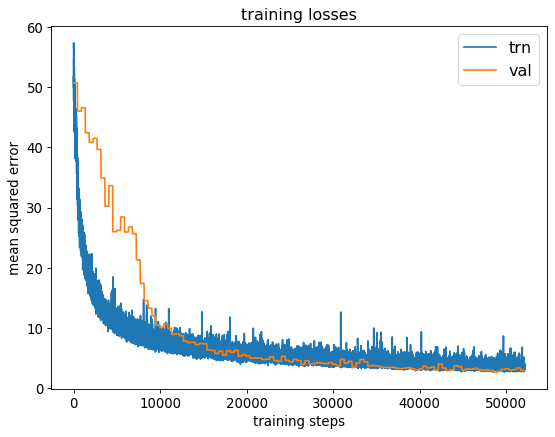

In [69]:
x_t = np.linspace(1, len(trn_losses), len(val_losses))
plt.plot(trn_losses)
plt.plot(x_t, val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.legend(["trn", "val"])
plt.show()

No. of validation steps: 1


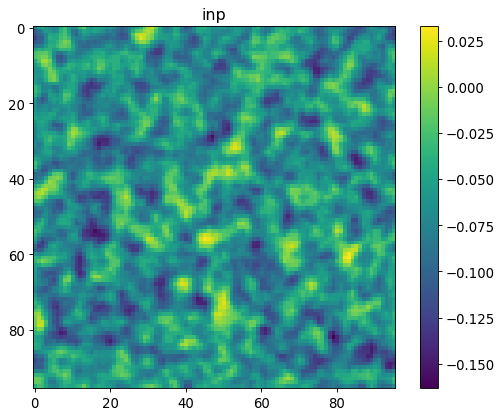

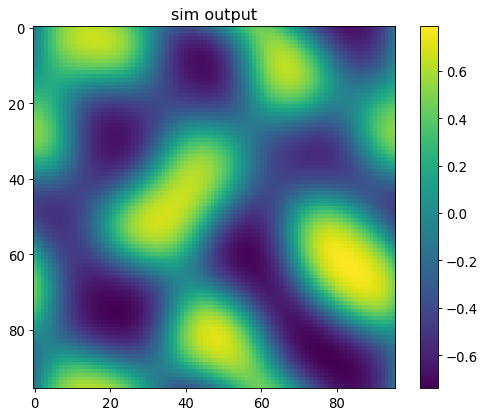

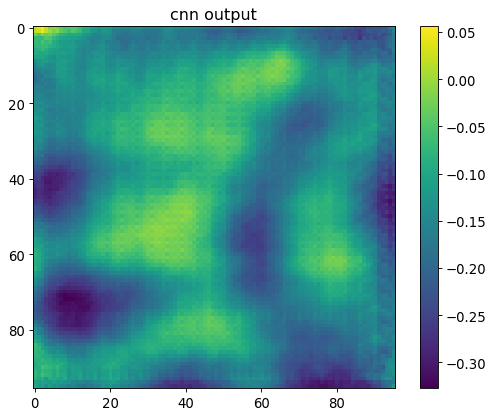

tensor(0.3915, device='cuda:0', dtype=torch.float64)


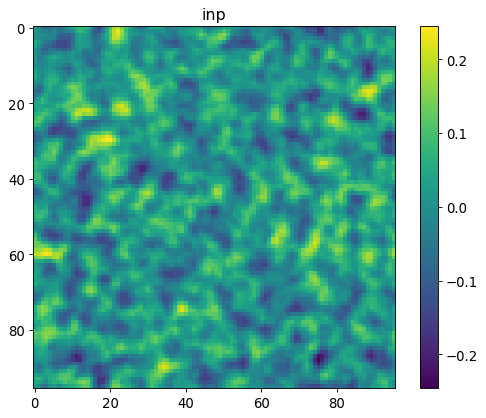

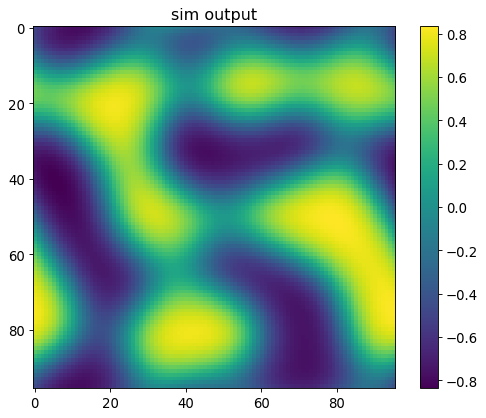

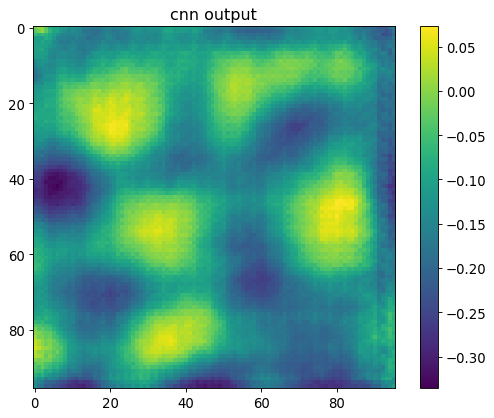

tensor(0.4503, device='cuda:0', dtype=torch.float64)
CPU times: user 2.4 s, sys: 3.8 s, total: 6.2 s
Wall time: 1.53 s


In [74]:
%%time
x_val, y_val = data_generator(nsamples=2, 
                              dim_x=96, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =174753,
                              device = device)

val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)

prd_losses = []
for item in val_loader:
    model.eval()
    x1 = item['x'].to(device)
    y1 = item['y'].to(device)
    # Forward pass
    y2, _ = model(x1)
    prd_losses.append(np.sqrt(criterion(y2, y1).item()))
print(np.mean(prd_losses), np.std(prd_losses))

ix = 0

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)
y2, _ = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

utils.draw_im(im_x1[0], "inp")

utils.draw_im(im_y1[0], "sim output")
utils.draw_im(im_y2[0], "cnn output")

print(rmse_loss(y1, y2).data)

ix = 1

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)
y2, _ = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

utils.draw_im(im_x1[0], "inp")

utils.draw_im(im_y1[0], "sim output")
utils.draw_im(im_y2[0], "cnn output")

print(rmse_loss(y1, y2).data)